# Introduction

Author: Jihoon Park (jhpark3@stanford.edu)

Two notebooks are prepared to demonstrate and reproduce results of the draft, *Direct forecasting of global and spatial model parameters from dynamic data* submitted to Computers and Geosciences (CAGEO_2019_892).

* Notebook1 (current) demonstrates how to apply direct forecasting of the model variables. 
* [Notebook2](Notebook2_Post-processing.ipynb) offers post-processing and results from iterations. 

In order to run code through jupyter notebook, [A Jupyter kernel for MATLAB](https://github.com/imatlab/imatlab) is required.

# Retrieve the data

The datasets can be downloaded [here](https://office365stanford-my.sharepoint.com/:f:/g/personal/jhpark3_stanford_edu/Ejde4i_PlJtBi4xuPvBH0KMBOK_RaM85vxulwQjZox1Wcw?e=b6Qmc7). The directoy `datafiles` must be located at upper directory as `../datafiles/`.

# Initialization

In [3]:
clear all; close all; fclose('all');
imatlab_export_fig('print-png')  % Notebook only to print figures inline

# Input

* `VarKeep_Spatial`: Variance (percent) to keep when applying PCA to model variable $m$.

* `Index`: Index of columns for specific responses from 3DSL output. 
* `MaxTimeHistory`: Data variables cover the responses from 0 to 7,500 day

In [5]:
VarKeep_Spatial = 95;

Index.Oilrate=4;
Index.Watercut=8;
Index.Time =2; 
MaxTimeHistory = 7500;
ReferenceNumber = 106;
FigSize_outputs = [319 215 1245 642];

WellNamesAll = {'P1','P2','P3','P4','P5','PNEW2'};
WellNamesData = {'P1','P2','P3','P4','P5'};
WellNamesPrediction = {'PNEW2'};

# Paths added

Paths are related to 1) FDA package, 2) DGSA, 3) helper functions, 4) Saved mat files, respectively.

In [6]:
addpath('../packages/fda_matlab/')
addpath('../packages/DGSA/');
addpath('../subroutines');
addpath(genpath('../datafiles/'));

# Spatial model variables, $m_{sp}$

## Load realizations of spatial variables

In [7]:
m_spatial = load(['SpatialParameters_Prior.mat']);
m_spatial = m_spatial.SpatialVariables;

In [8]:
Reference_spatial = m_spatial(ReferenceNumber,:);
NbRealz = size(m_spatial,1);

## Visualize some of realizations
There are 15 layers in Libyan oilfield and each layer can be selected for visualization. 
For example, below code visualizes 1st, 4,7,10,13,15th layers of the reference field with 3 rows and colorbars ranging from \[2,6\].

```matlab
DisplayZSliceFrom3D(3,m_spatial,ReferenceNumber,127,165,15,[1,4,7,10,13,15],[2,6]);
```

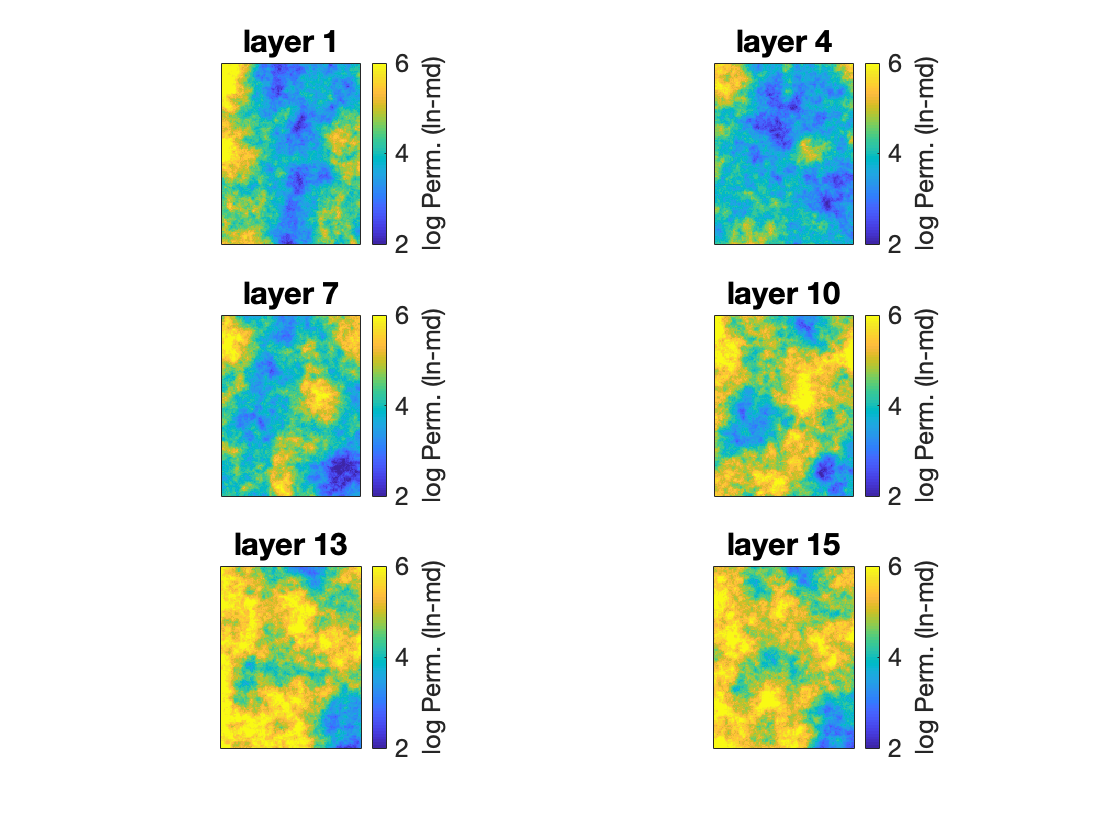

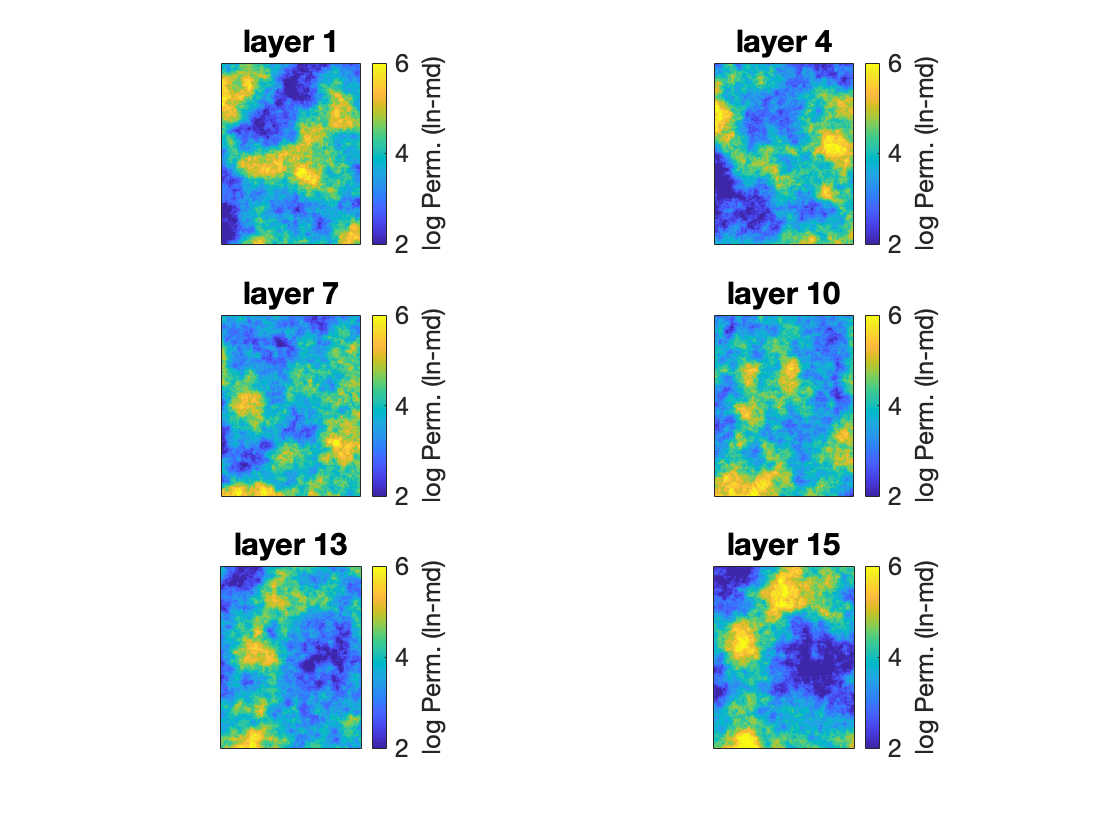

In [11]:
DisplayZSliceFrom3D(3,m_spatial,ReferenceNumber,127,165,15,[1,4,7,10,13,15],[2,6]);
DisplayZSliceFrom3D(3,m_spatial,55,127,165,15,[1,4,7,10,13,15],[2,6]); 

## Orthogonalization of Spatial variable $m_{sp}$ by PCA

The variables for PCA of the spatial variables will be saved in structure array,`PCAInfo.spatial`. Each field indicates as follows

* score_All: PC scores 
* coeff_All: PC loadings
* explained: variance explained by each PC
* CumulVar: cumulative variance
* NumPC_Selected: numbers of PCs selected, controlled by `VarKeep_Spatial`
* score: PC scores seleted by `.NumPC_Selected`
* coeff: PC loadings selected by `.NumPC_Selected`
* muzscore: mean of spatial variables
* sigmazscore: std of spatial variables

The score variables need to be standardized first.

In [12]:
[m_spatial,PCAInfo_spatial.muzscore,PCAInfo_spatial.sigmazscore]=zscore(m_spatial);
PCAInfo_spatial.mu = mean(m_spatial,1); 

## Apply PCA to $m_{sp}$

Applying built-in function `pca` to $m_{sp}$ can cause memory error due to high dimensionalty. This problem can be circumvented by performing eigenvalue decomposition of `m_spatial*m_spatial'` intead of `m_spatial'*m_spatial`, where `m_spatial.shape = (NbRealz, NumOfGridCells)`. In order to minimize overhead, this process is not performed with helper functions. 

In [13]:
[V2,D2]=eig((m_spatial*m_spatial')/(NbRealz-1)); 
[e2,i2] = sort(diag(D2), 'descend');
V_sorted2=V2(:,i2);
coeff=m_spatial'*V_sorted2;
coeff=normc(coeff);

for iii=1:size(coeff,2)
    [~,idx]=max(abs(coeff(:,iii)),[],1);
    coeff(:,iii)=sign(coeff(idx,iii))*coeff(:,iii);

end

score = m_spatial*coeff;
explained = 100*e2/sum(e2); 

PCAInfo_spatial.explained = explained;
PCAInfo_spatial.CumulVar = cumsum(explained); 
PCAInfo_spatial.NumPC_Selected = find(PCAInfo_spatial.CumulVar>VarKeep_Spatial); 
PCAInfo_spatial.NumPC_Selected = PCAInfo_spatial.NumPC_Selected(1);

fprintf('Explained Var: %.1f percent, Num PCs chosen: %i\n',VarKeep_Spatial,PCAInfo_spatial.NumPC_Selected);

PCAInfo_spatial.score_Selected = score(:,1:PCAInfo_spatial.NumPC_Selected);
PCAInfo_spatial.coeff_Selected = coeff(:,1:PCAInfo_spatial.NumPC_Selected);

PCAInfo_spatial.score_All = score;
PCAInfo_spatial.coeff_All = coeff;


clear coeff score V2 D2 e2 i2

Explained Var: 95.0 percent, Num PCs chosen: 373


## See first two PC scores and scree plot

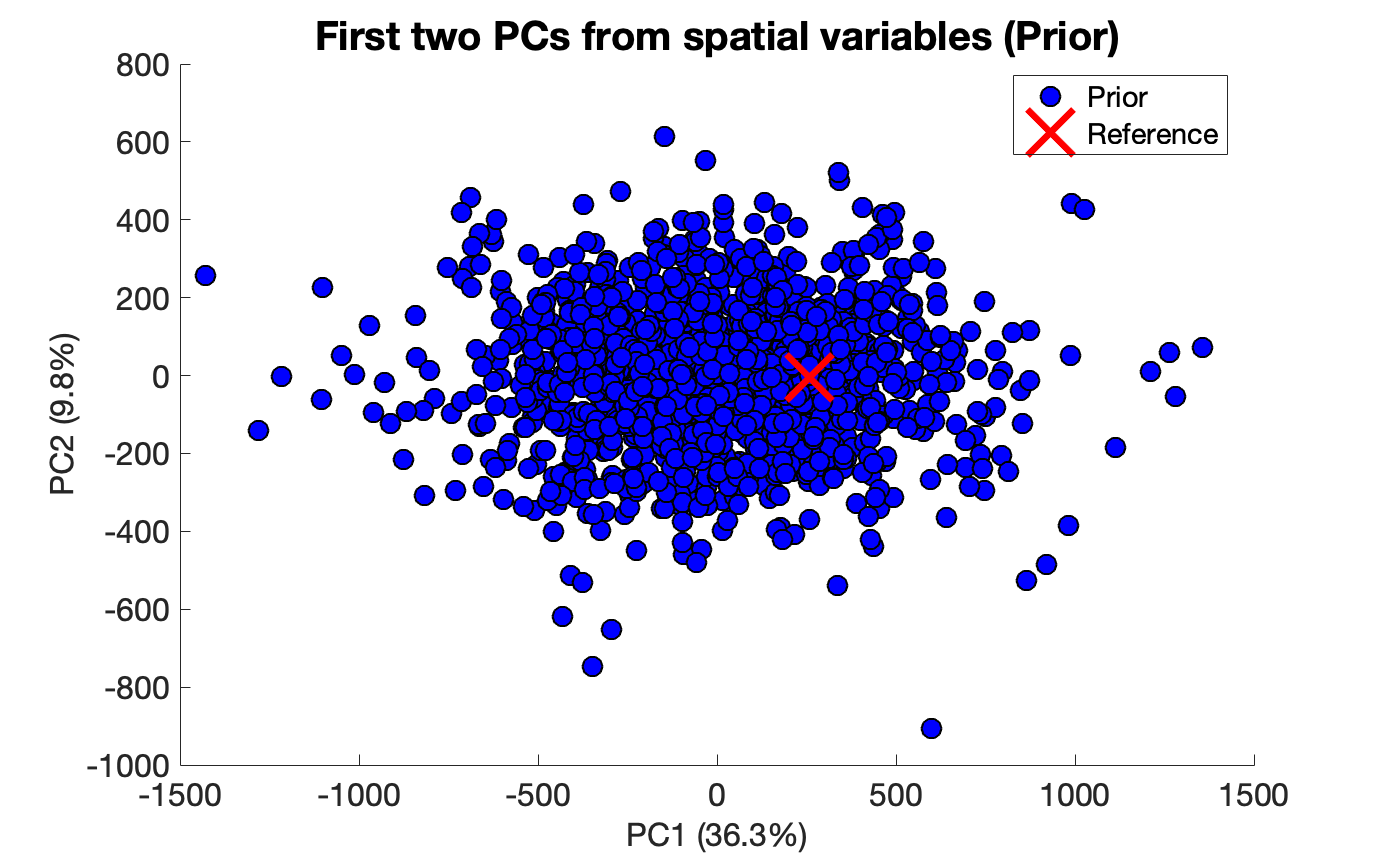

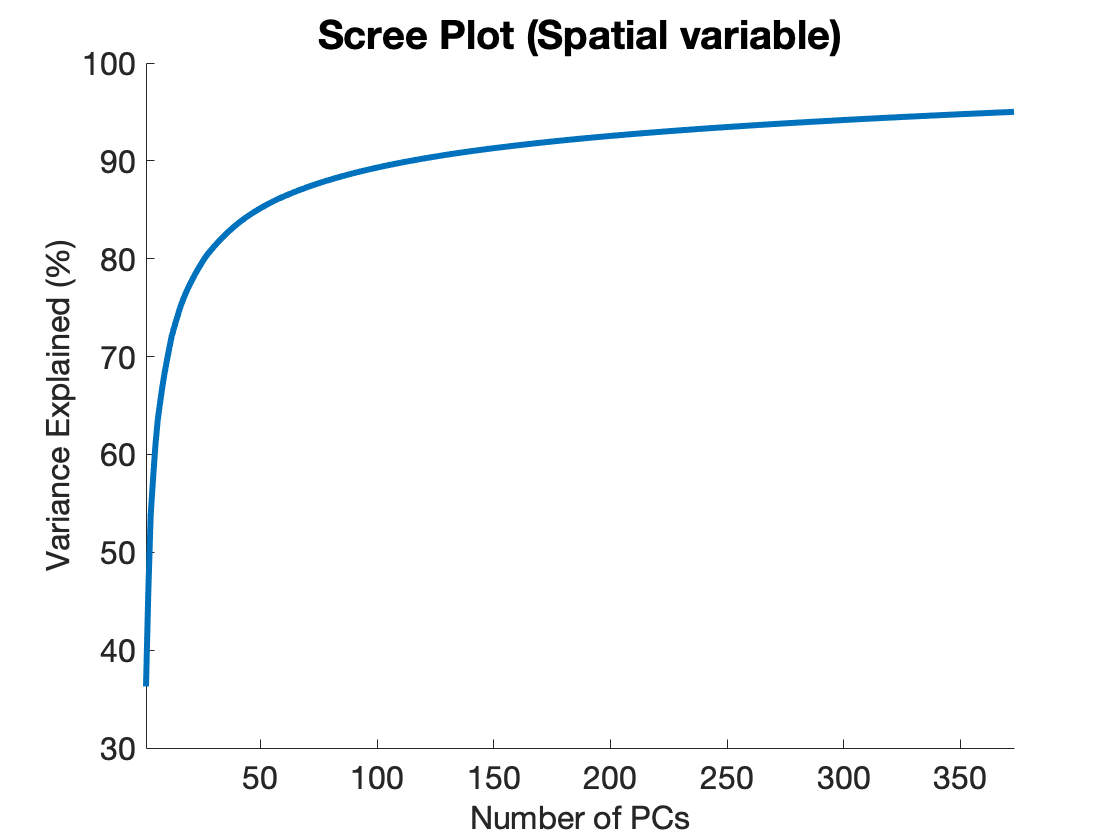

In [15]:
DisplayScores2D(PCAInfo_spatial.score_Selected,[1,2],ReferenceNumber,'First two PCs from spatial variables (Prior)',...
PCAInfo_spatial.explained)

DisplayCumulativeVar(PCAInfo_spatial.CumulVar,'Scree Plot (Spatial variable)',PCAInfo_spatial.NumPC_Selected);

## Visualize some eigenimages

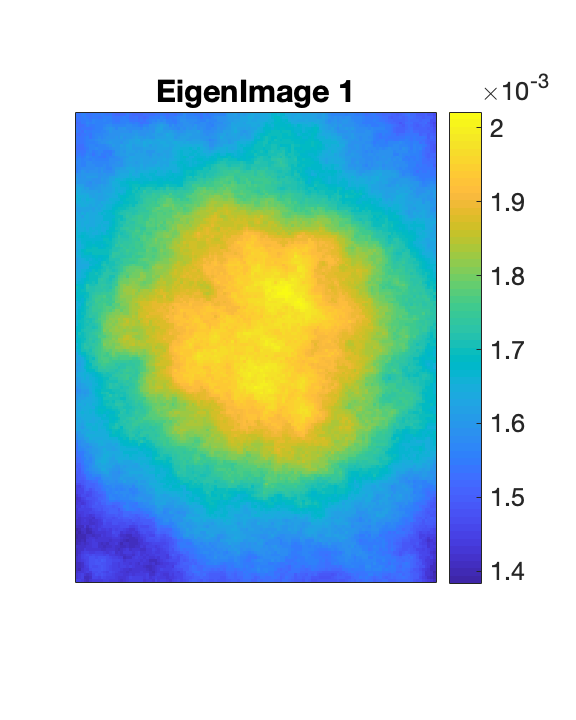

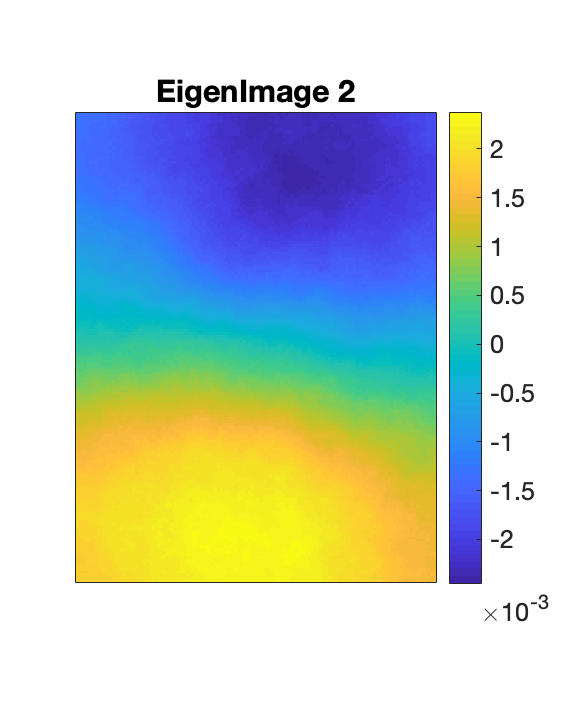

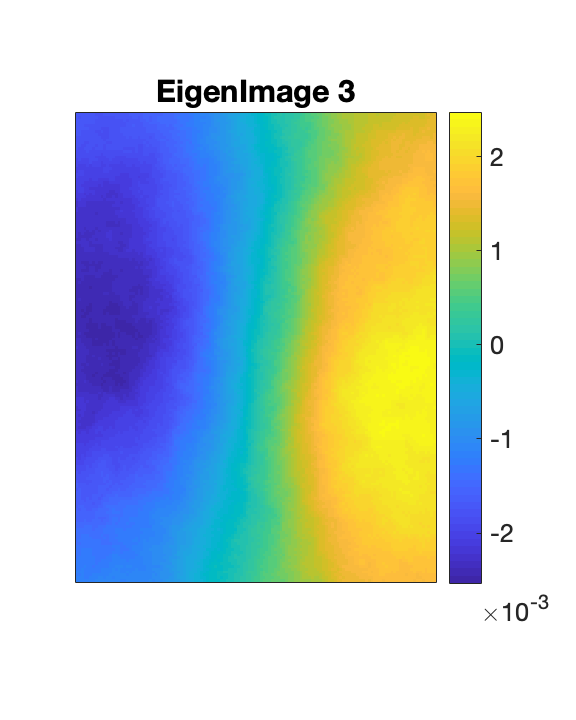

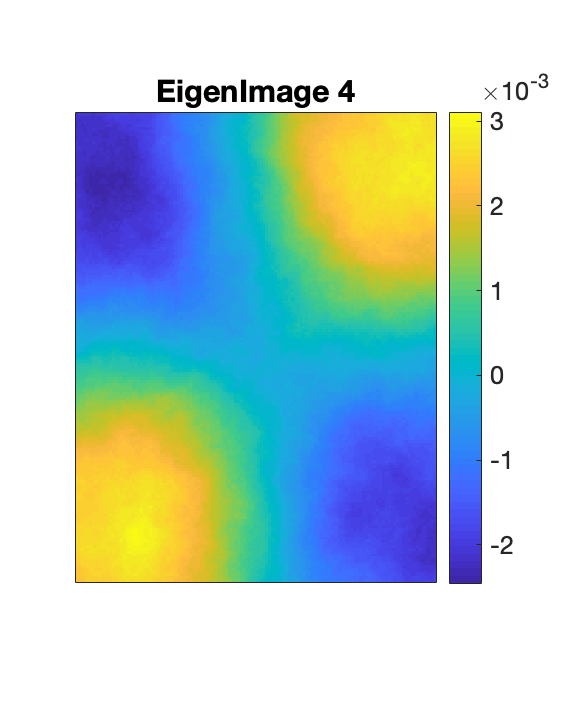

In [16]:
DisplayZSliceFrom3D_EI(1,PCAInfo_spatial.coeff_Selected',1,127,165,15,[1]); 
DisplayZSliceFrom3D_EI(1,PCAInfo_spatial.coeff_Selected',2,127,165,15,[1]); 
DisplayZSliceFrom3D_EI(1,PCAInfo_spatial.coeff_Selected',3,127,165,15,[1]); 
DisplayZSliceFrom3D_EI(1,PCAInfo_spatial.coeff_Selected',4,127,165,15,[1]); 

# Load global parameters

Global parameters, $m_{gl}$ consists of 14 parameters. Three parameters are related to generation of spatial variables (`GlobalGS`) and 14 parameters are related to other sources of uncertainty (`GlobalnonGS`).

In [17]:
load(['GlobalParameters_Prior.mat'])

# Response variables

## Preprocessing

Load the data from 3DSL output:

In [18]:
load('PriorSimulationResults.mat')

The below code block defines timesteps for data and predition variables. Each case might have different timesteps for sake of numerical stability of streamline simulation. All the values will be interpolated according to `ReferenceTimeStep`.

In [19]:
ReferenceTimeStep.All = Data{ReferenceNumber}.(WellNamesAll {1})(:,2);  
ReferenceTimeStep.Data = ReferenceTimeStep.All(ReferenceTimeStep.All<=MaxTimeHistory);
ReferenceTimeStep.Prediction = ReferenceTimeStep.All(ReferenceTimeStep.All>MaxTimeHistory);

Convert the values to populate the matrices 

In [20]:
% Convert the data sturctures for preprecessing

% Data variable, Oil rate
[PriorDataOilrate,PriorDataTimeStep]=Convert_3DSL_Response(Data,Index.Oilrate,WellNamesData,ReferenceTimeStep.Data,Index.Time);

% Data variable, Watercut
PriorDataWatercut = Convert_3DSL_Response(Data,Index.Watercut,WellNamesData,ReferenceTimeStep.Data,Index.Time);

PriorDataWatercut = PriorDataWatercut/100; 

% Prediction variable, Oil rate
[PriorPredictionOilrate,PriorPredictionTimeStep] = Convert_3DSL_Response(Data,Index.Oilrate,WellNamesPrediction,ReferenceTimeStep.Prediction,Index.Time);

% Prediction variable, Watercut
PriorPredictionWatercut = Convert_3DSL_Response(Data,Index.Watercut,WellNamesPrediction,ReferenceTimeStep.Prediction,Index.Time);
PriorPredictionWatercut = PriorPredictionWatercut/100;

Split the observed (named history) and simulated data

In [21]:
% Split data variables
[Prior.Data.Oilrate.History,Prior.Data.Oilrate.Simulated] = SplitDataObservedSimulated(PriorDataOilrate,ReferenceNumber);
[Prior.Data.Watercut.History,Prior.Data.Watercut.Simulated] = SplitDataObservedSimulated(PriorDataWatercut, ReferenceNumber);

% Split prediction variables
[Prior.Prediction.Oilrate.History,Prior.Prediction.Oilrate.Simulated] = SplitDataObservedSimulated(PriorPredictionOilrate,ReferenceNumber);

Now, we can visualize the responses. In this example, 300 realizations are randomly selected for visualization. It should be noted that this selection is for visualization only - every case is used for further computations.

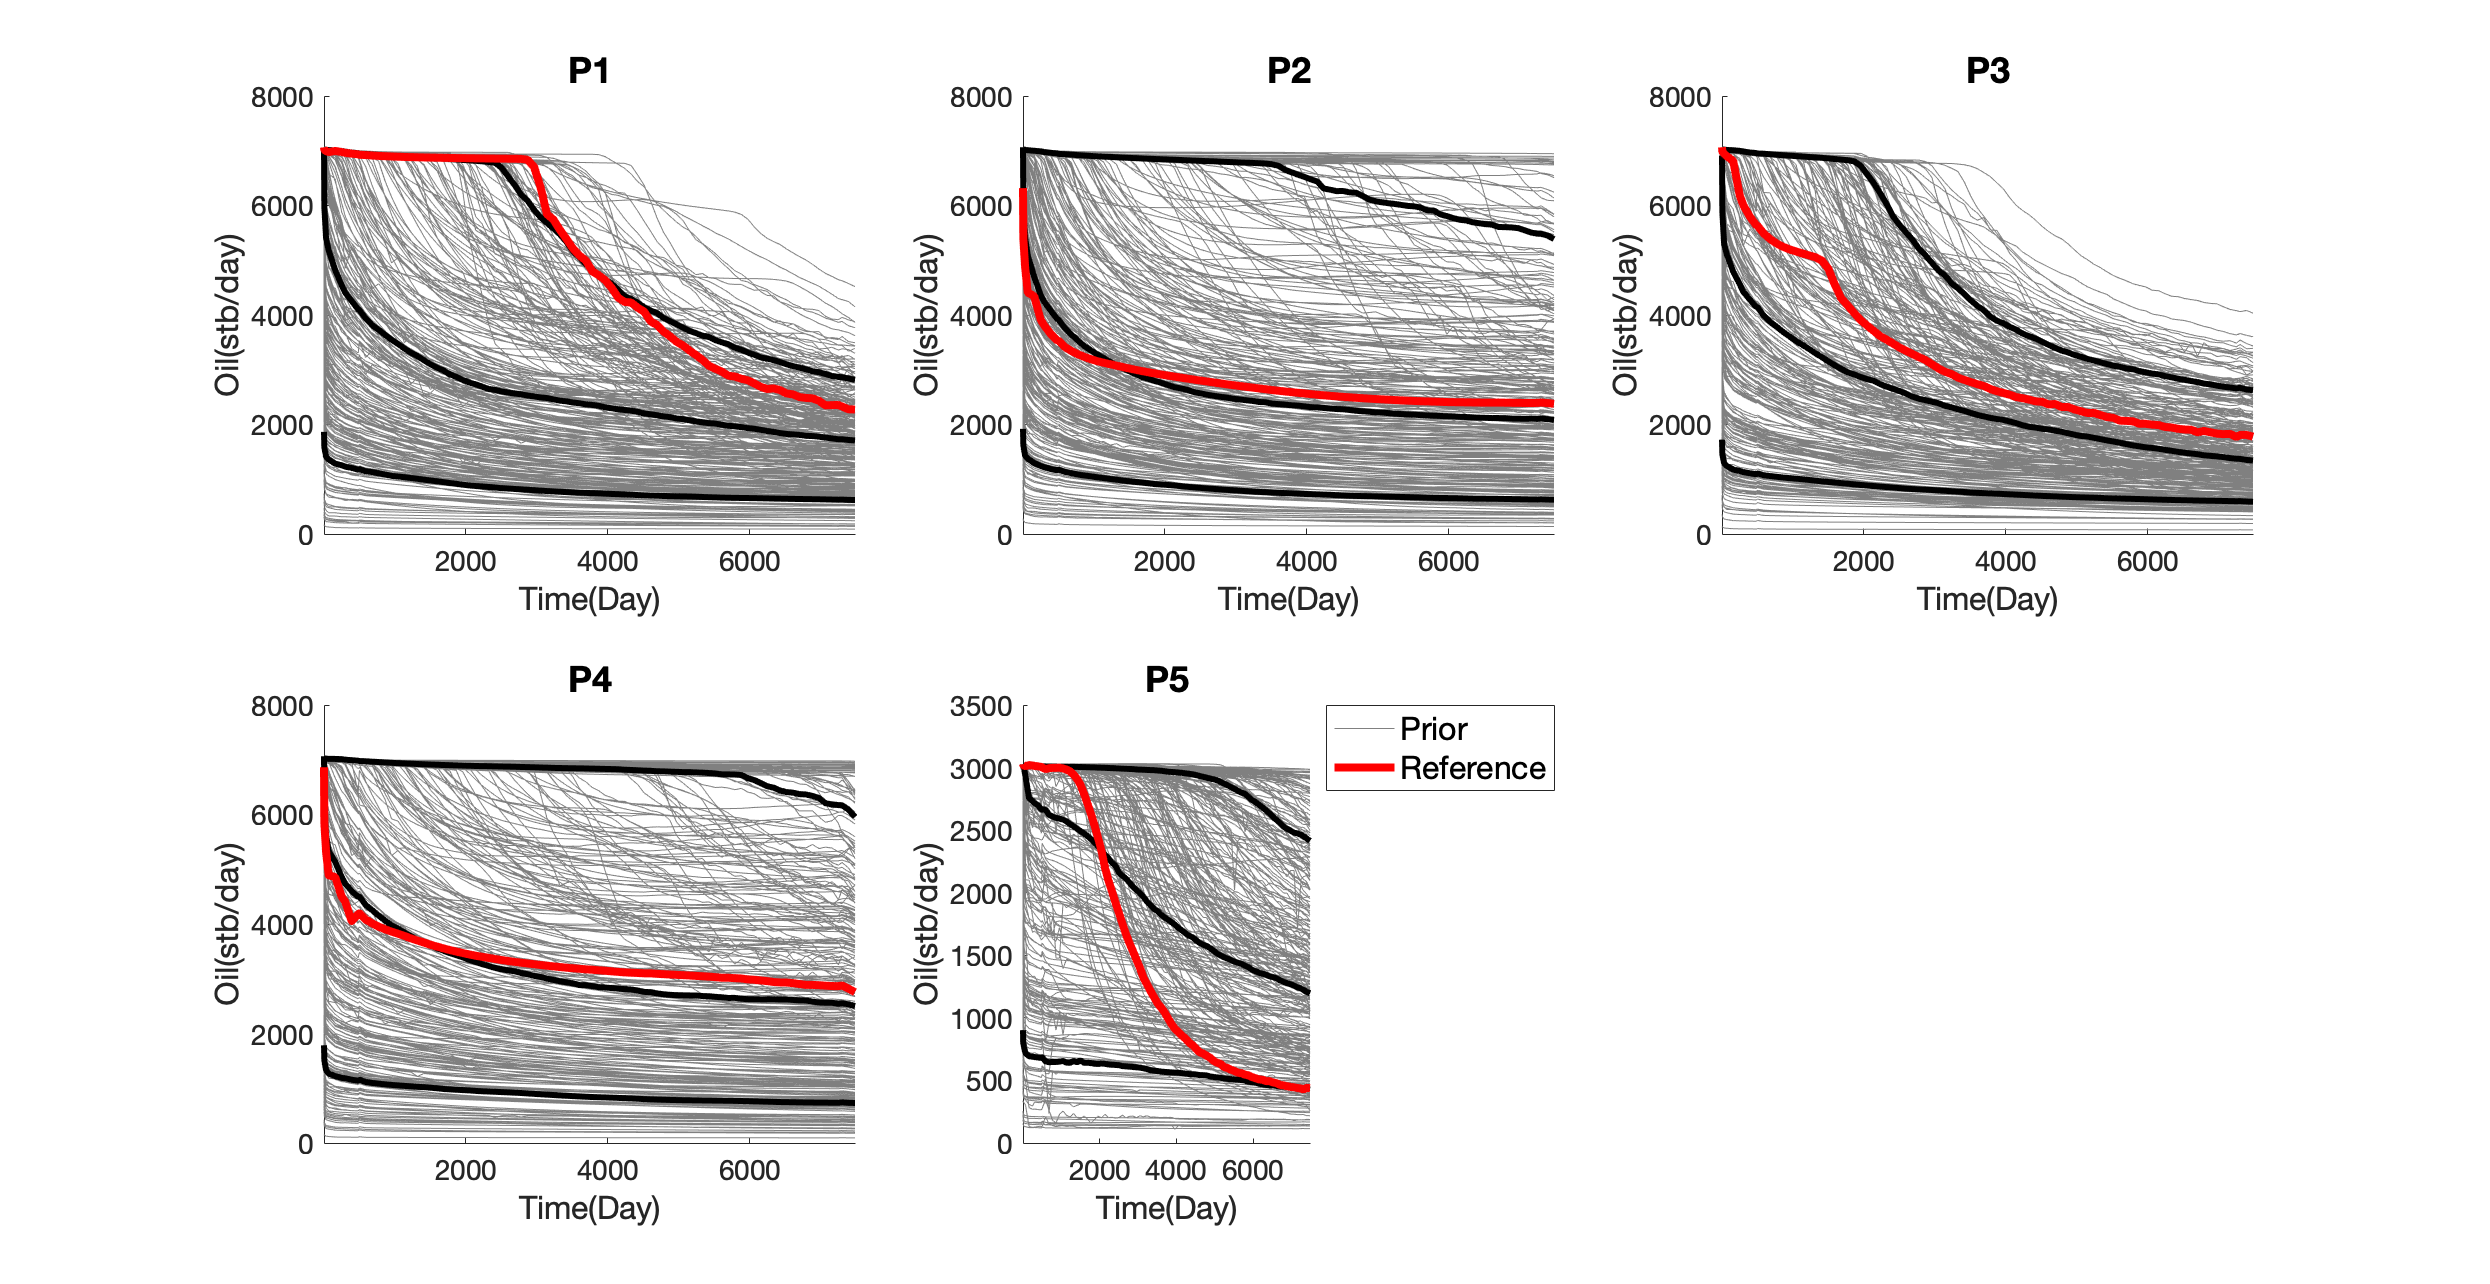

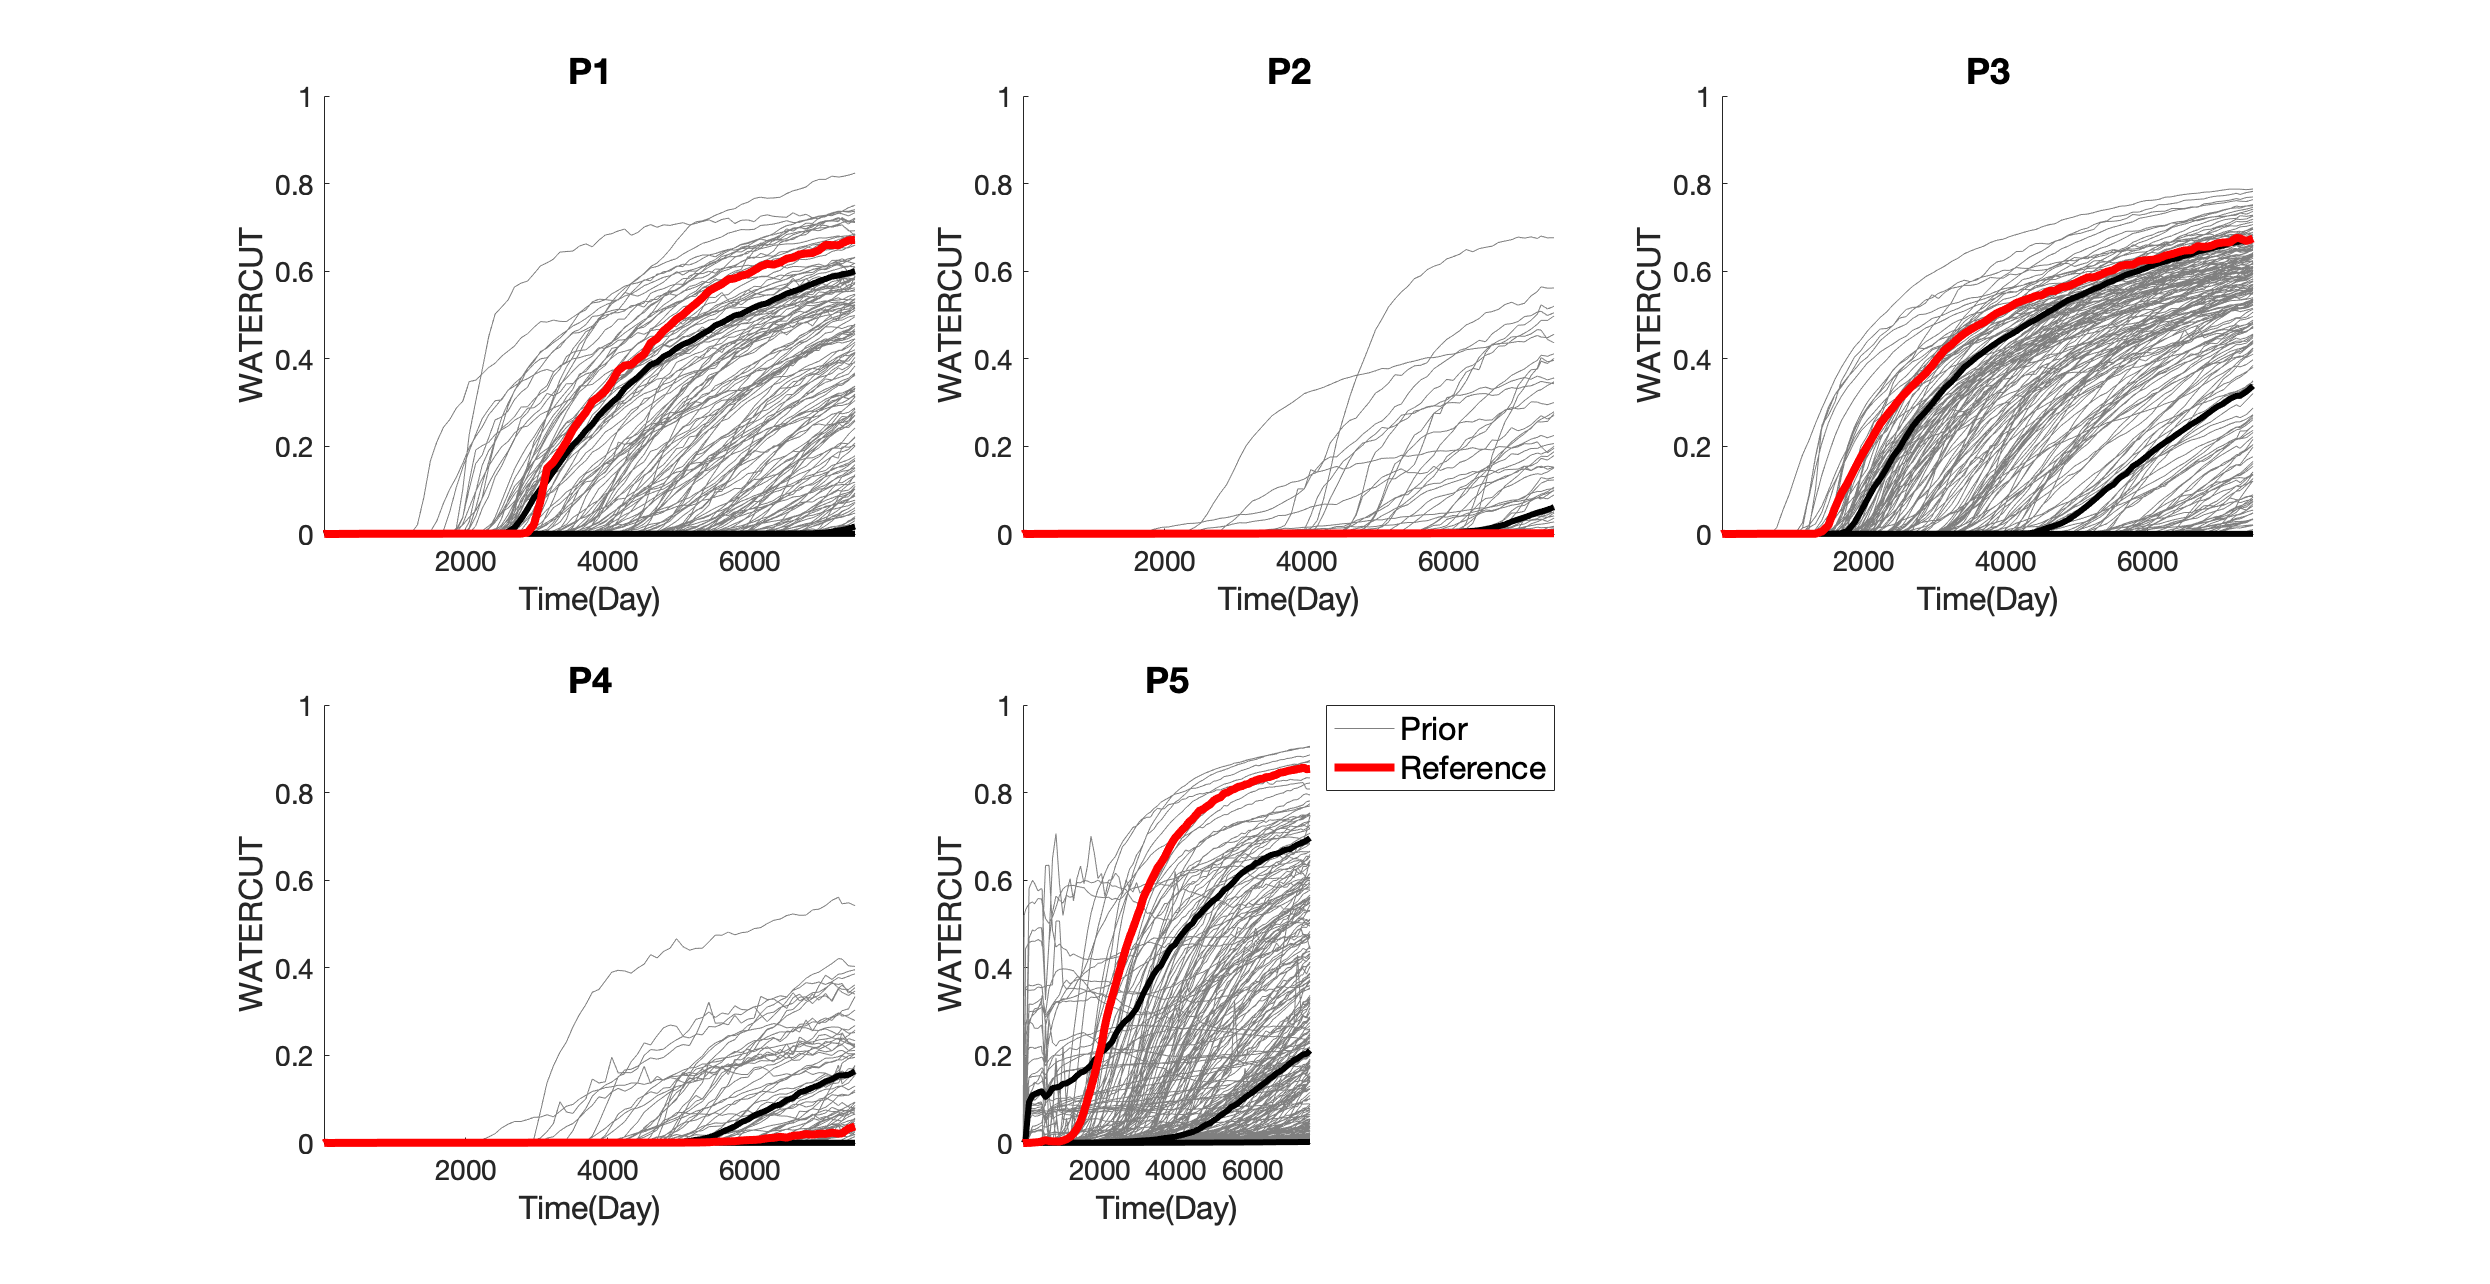

In [23]:
PlotFlowResponses_with_sampling(PriorDataTimeStep,WellNamesData,...
    Prior.Data.Oilrate.Simulated,Prior.Data.Oilrate.History,2,true,'Oil(stb/day)',300,134,FigSize_outputs);

PlotFlowResponses_with_sampling(PriorDataTimeStep,WellNamesData,...
    Prior.Data.Watercut.Simulated,Prior.Data.Watercut.History,2,true,'WATERCUT',300,134,FigSize_outputs);


## Functional Data Analysis (FDA) on data and prediction variables

### Specify FDA parameters

In [24]:
FDA_Parameters_data=struct('norder',3,'nknots',30,...
    'StartTime',0,'EndTime',7500,'Type','bspline','tgrid',PriorDataTimeStep); 

FDA_Parameters_data.nbasis=FDA_Parameters_data.nknots+FDA_Parameters_data.norder-2;

### Run Functional Data Analysis and Functional PCA 

Run FDAand FPCA for data variables

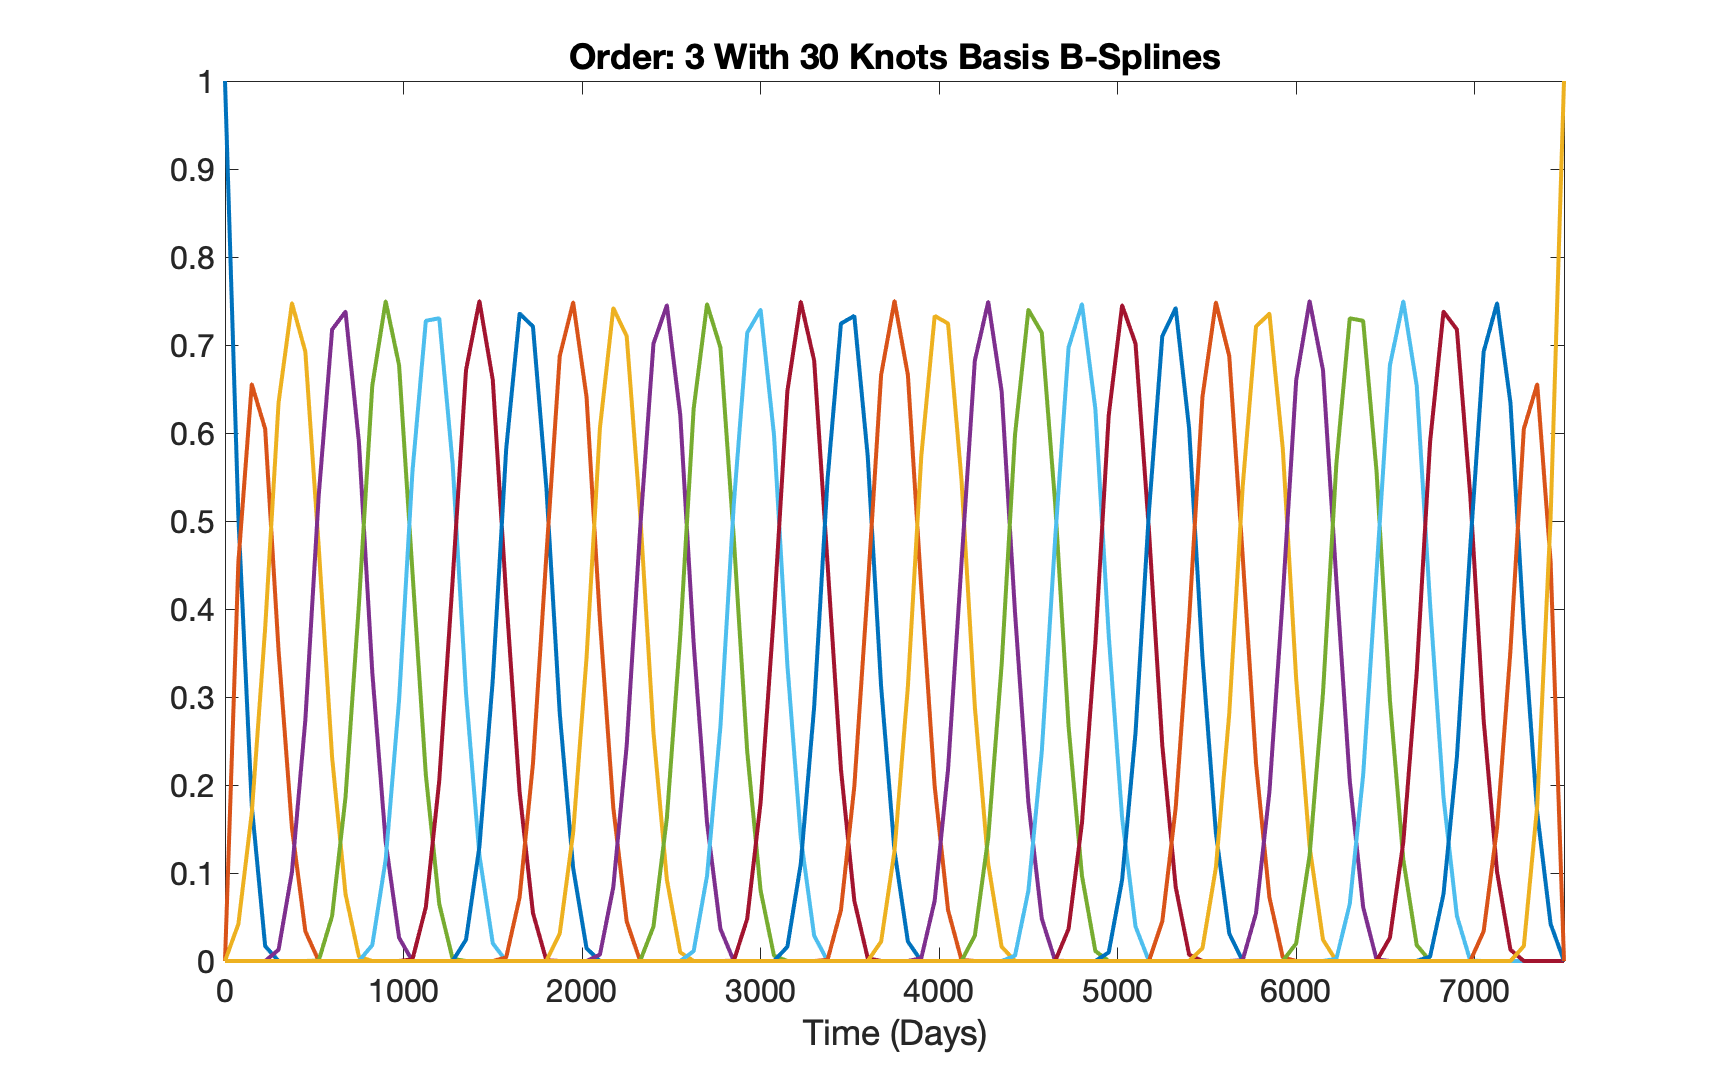

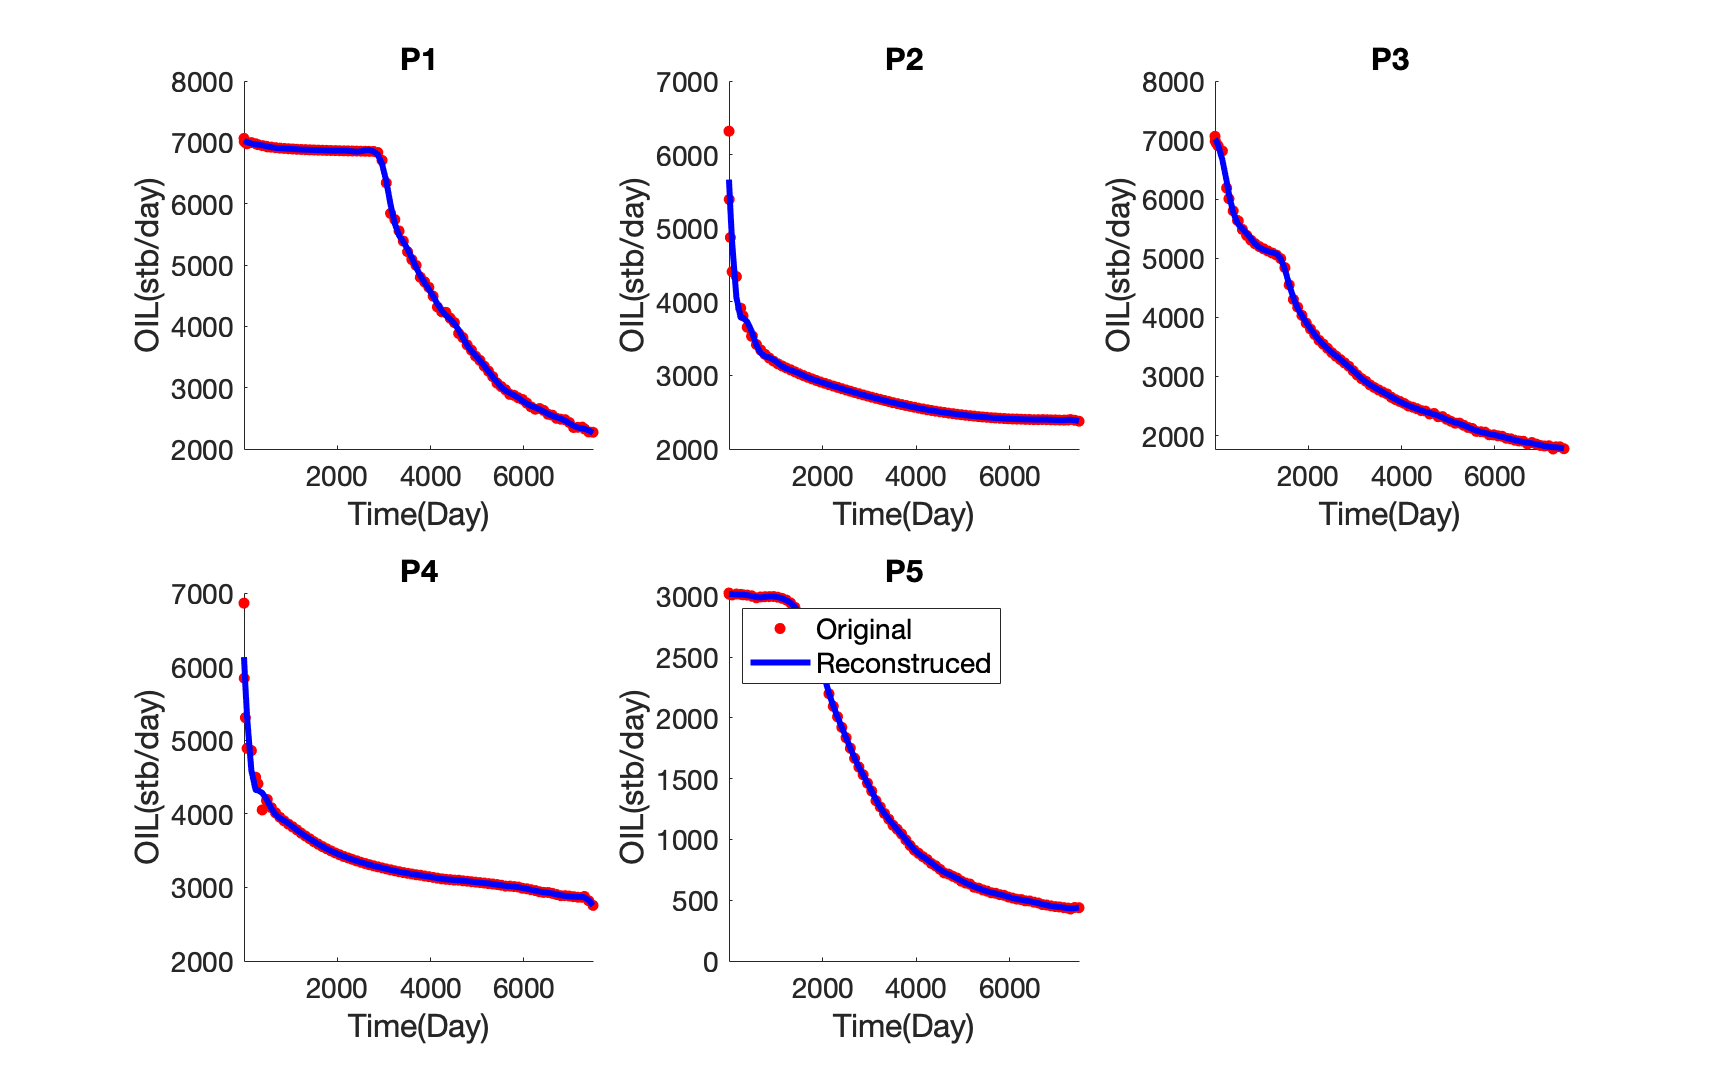

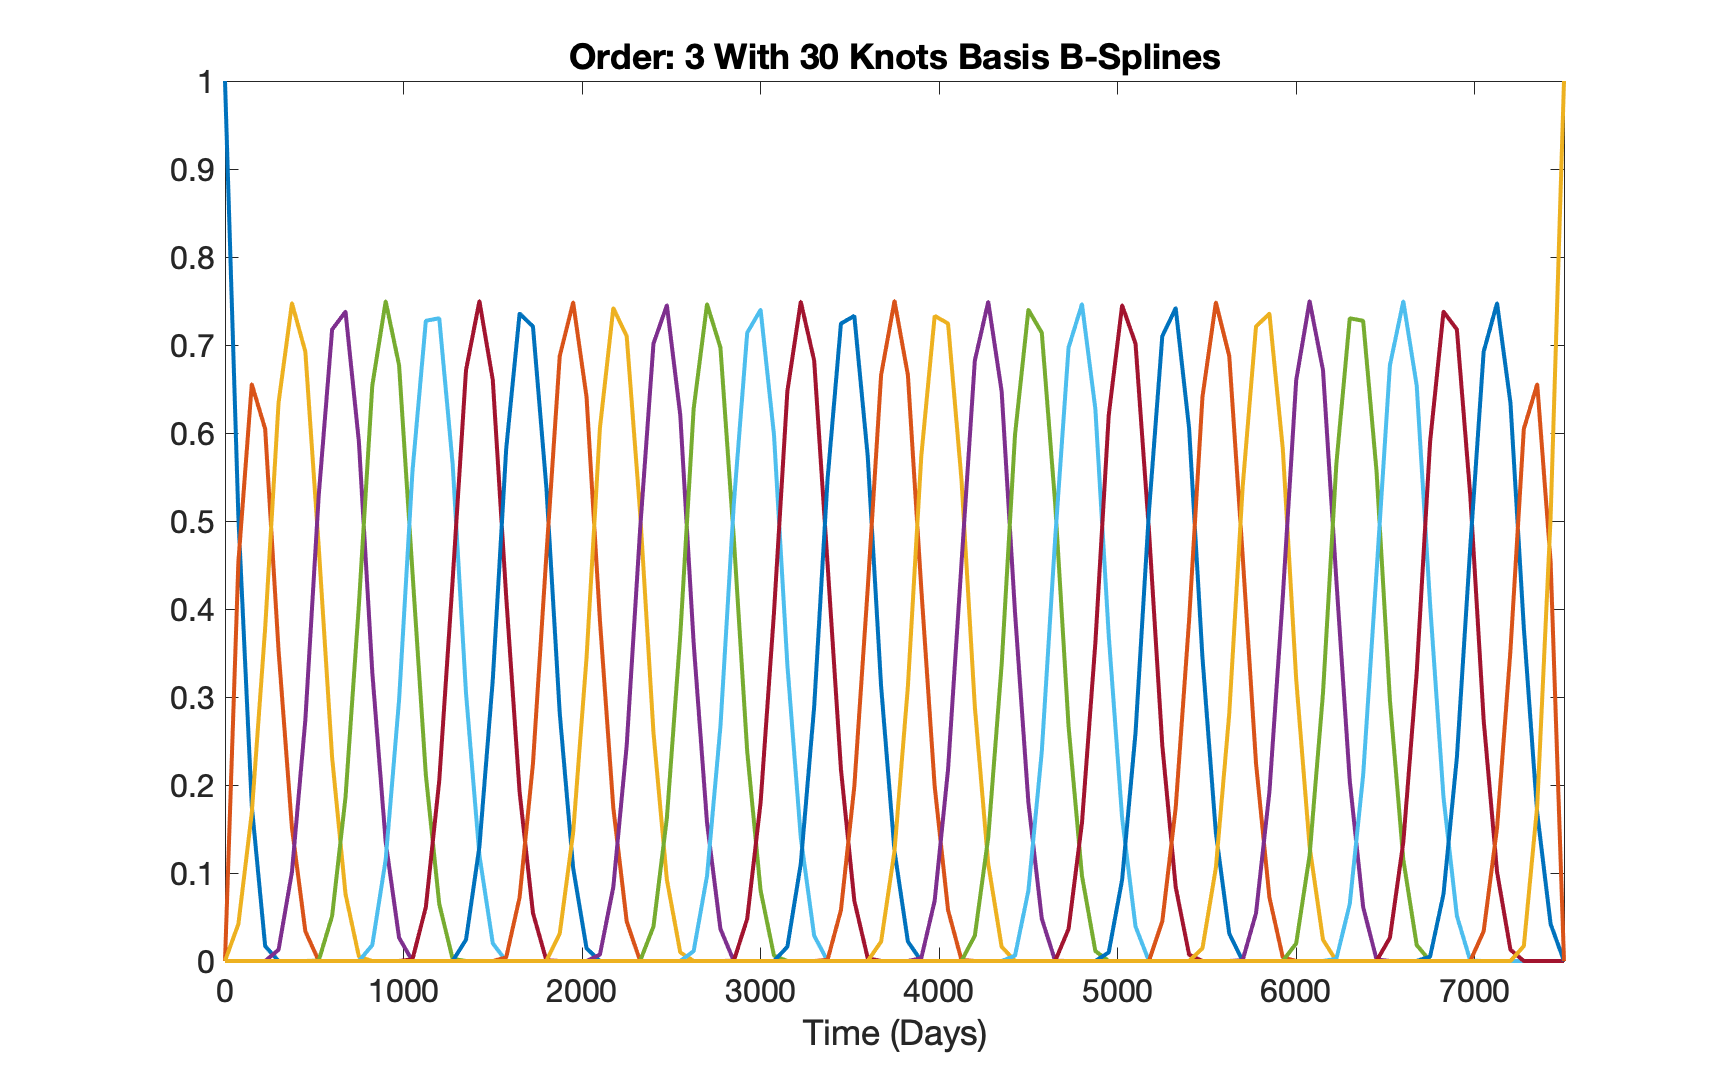

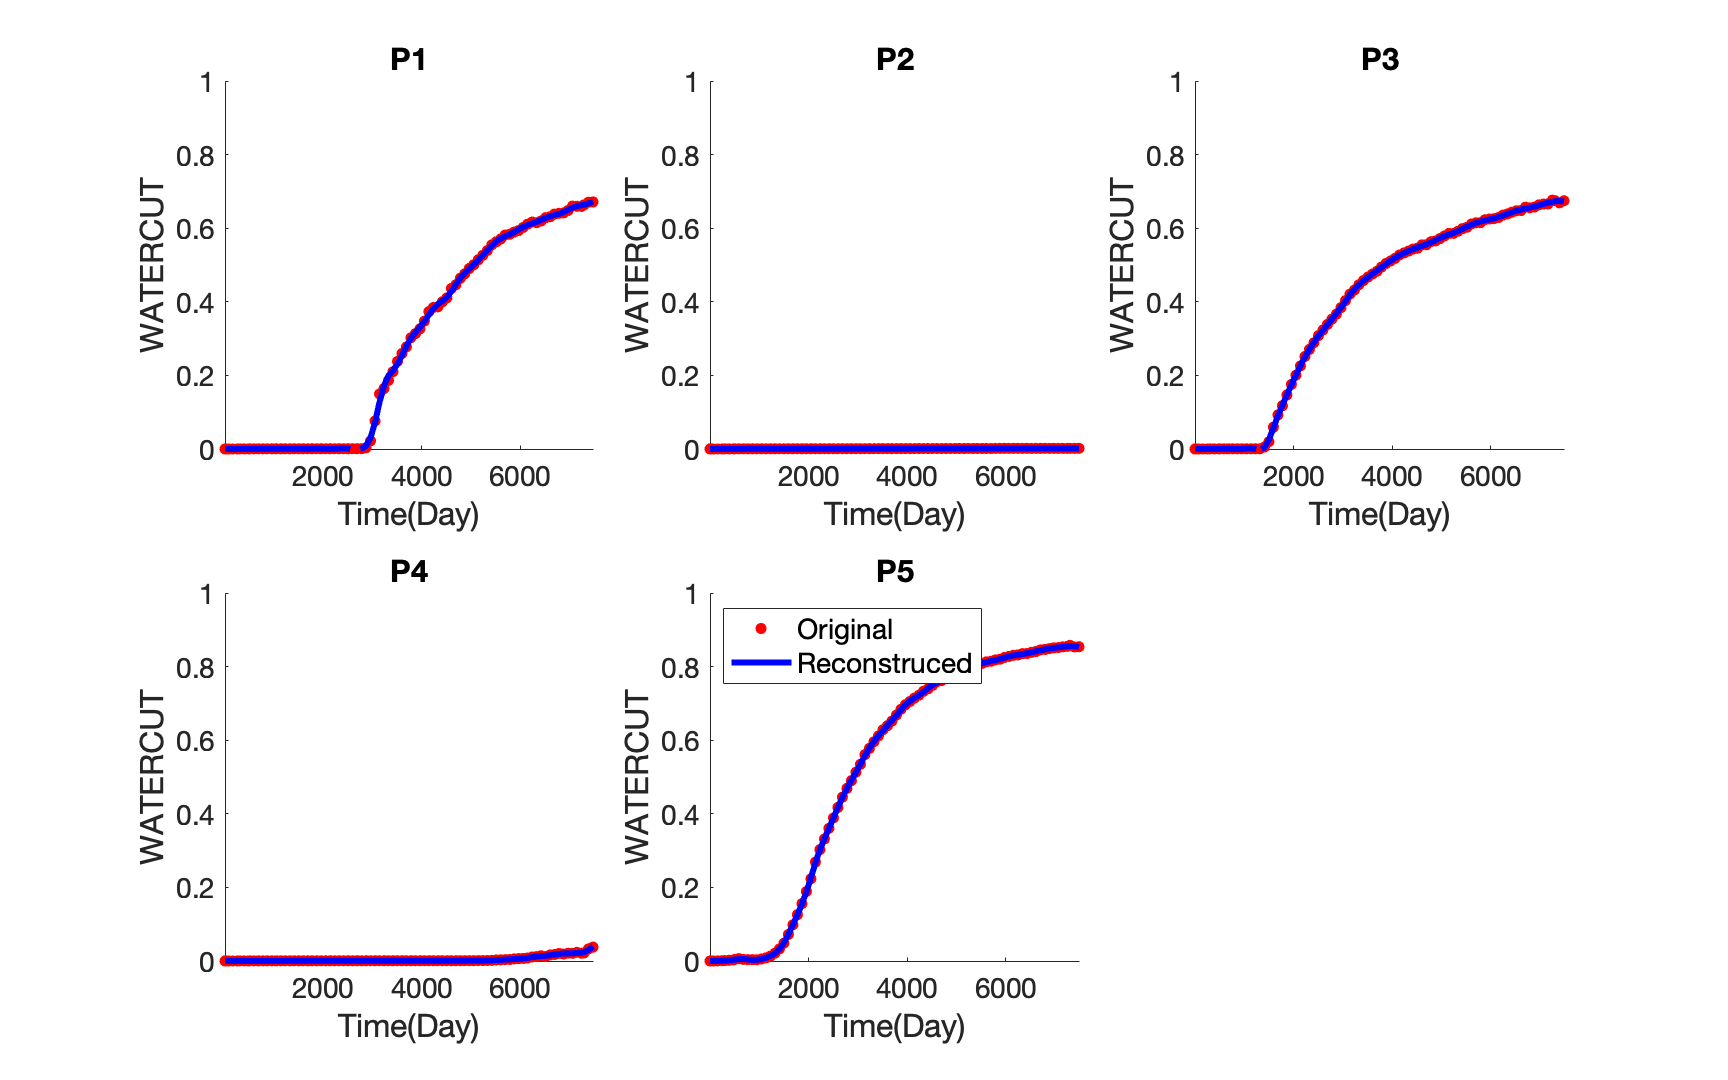

In [25]:
FPCA_Oilrate_data=PerformFDA_FPCA(FDA_Parameters_data,PriorDataTimeStep,PriorDataOilrate,[ReferenceNumber],2,WellNamesData,true,'OIL(stb/day)');
FPCA_Watercut_data=PerformFDA_FPCA(FDA_Parameters_data,PriorDataTimeStep,PriorDataWatercut,[ReferenceNumber],2,WellNamesData,true,'WATERCUT');

We repeat the same procedures for the prediction variables

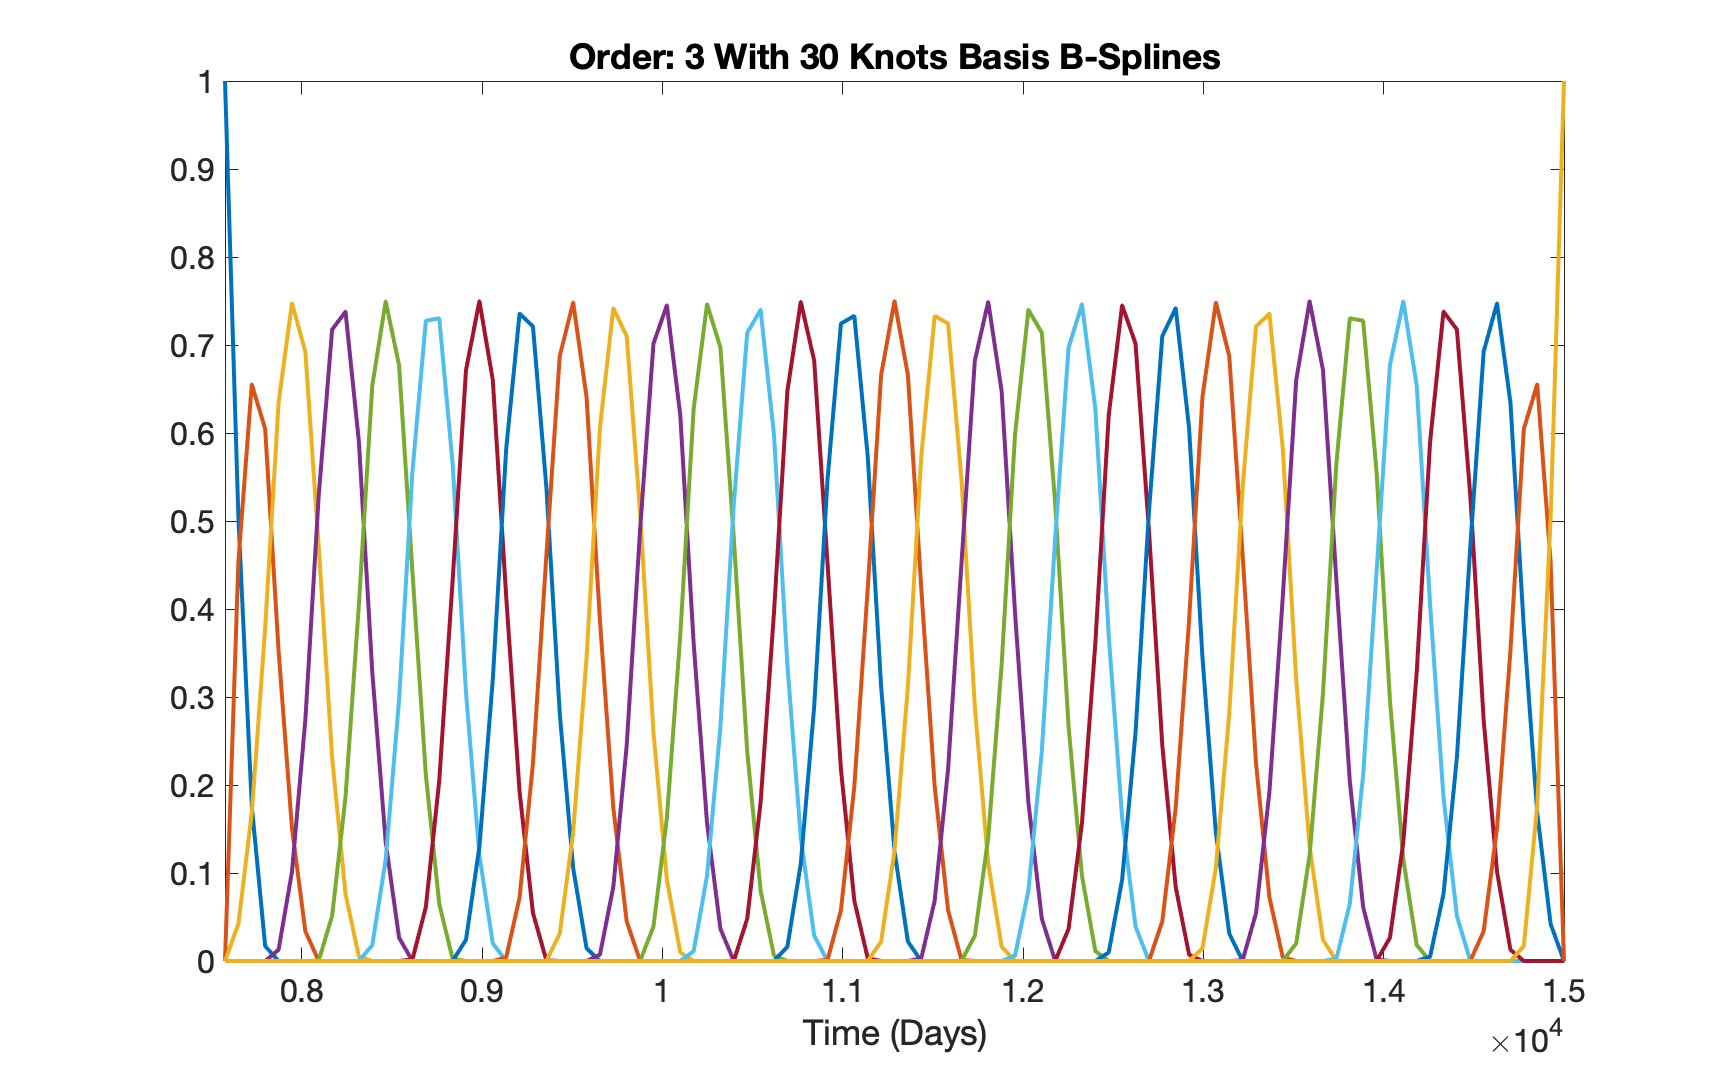

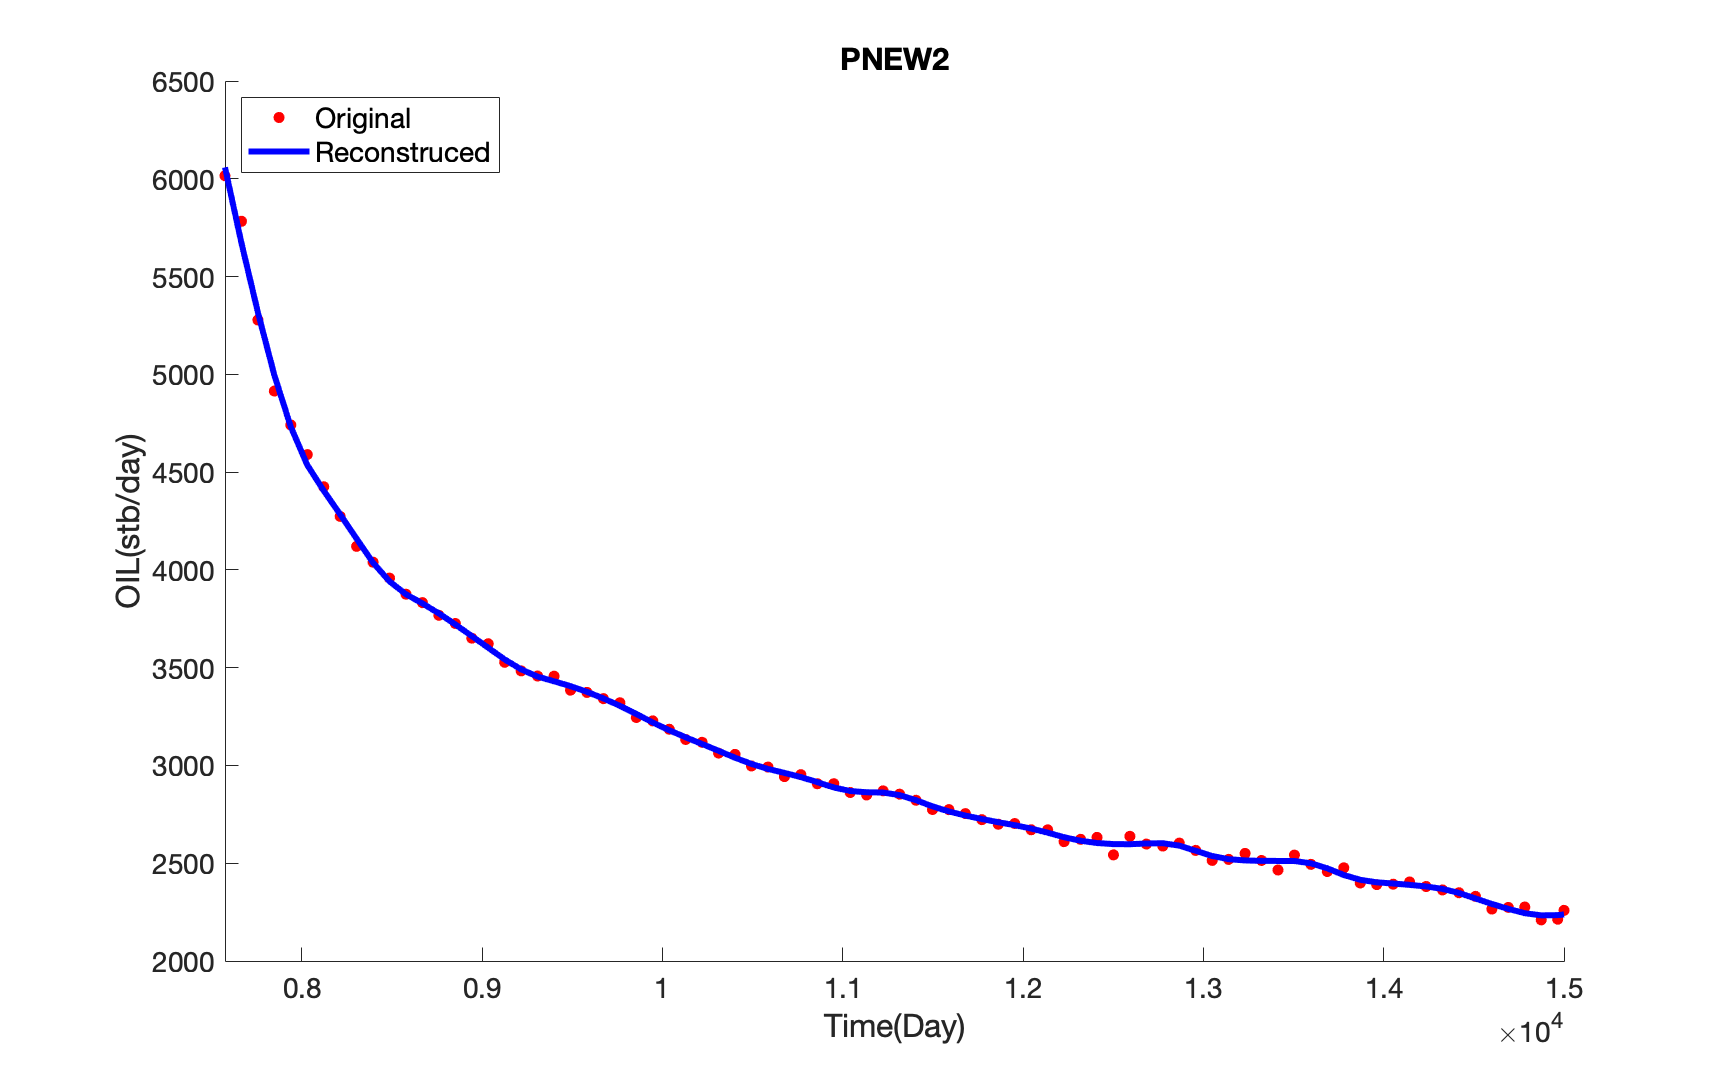

In [26]:
FDA_Parameters_prediction=struct('norder',3,'nknots',30,...
    'StartTime',ReferenceTimeStep.Prediction(1),'EndTime',ReferenceTimeStep.Prediction(end),'Type','bspline','tgrid',PriorPredictionTimeStep); 

FDA_Parameters_prediction.nbasis=FDA_Parameters_prediction.nknots+FDA_Parameters_prediction.norder-2;

FPCA_Oilrate_prediction=PerformFDA_FPCA(FDA_Parameters_prediction,PriorPredictionTimeStep,PriorPredictionOilrate,[ReferenceNumber],1,WellNamesPrediction,true,'OIL(stb/day)');

### Mixed PCA

Now we apply mixed PCA for each variable to remove spatial correlation (orthogonalization).

In [27]:
[Prior.Data.Oilrate.Mixed,Prior.Data.Oilrate.ReconstructedCurvesFromMixed]...
    =PerformMixedPCA_fromFPCA(PriorDataTimeStep,FPCA_Oilrate_data,99.999,[]);%

[Prior.Data.Watercut.Mixed,Prior.Data.Watercut.ReconstructedCurvesFromMixed] ... 
    =PerformMixedPCA_fromFPCA(PriorDataTimeStep,FPCA_Watercut_data,99.999,[]);

[Prior.Prediction.Oilrate.Mixed,Prior.Prediction.Oilrate.ReconstructedCurvesFromMixed] ... 
    =PerformMixedPCA_fromFPCA(PriorPredictionTimeStep,FPCA_Oilrate_prediction,99.9999,[]);

For data variable, additional correlation between oilrate and watercut needs to be removed.

In [28]:
rmpath('../packages/fda_matlab/')
Prior.Data.MixedAll = MixedPCA_phase([Prior.Data.Oilrate.Mixed,...
    Prior.Data.Watercut.Mixed],99.9999,[]);

Let's see first two PC scores

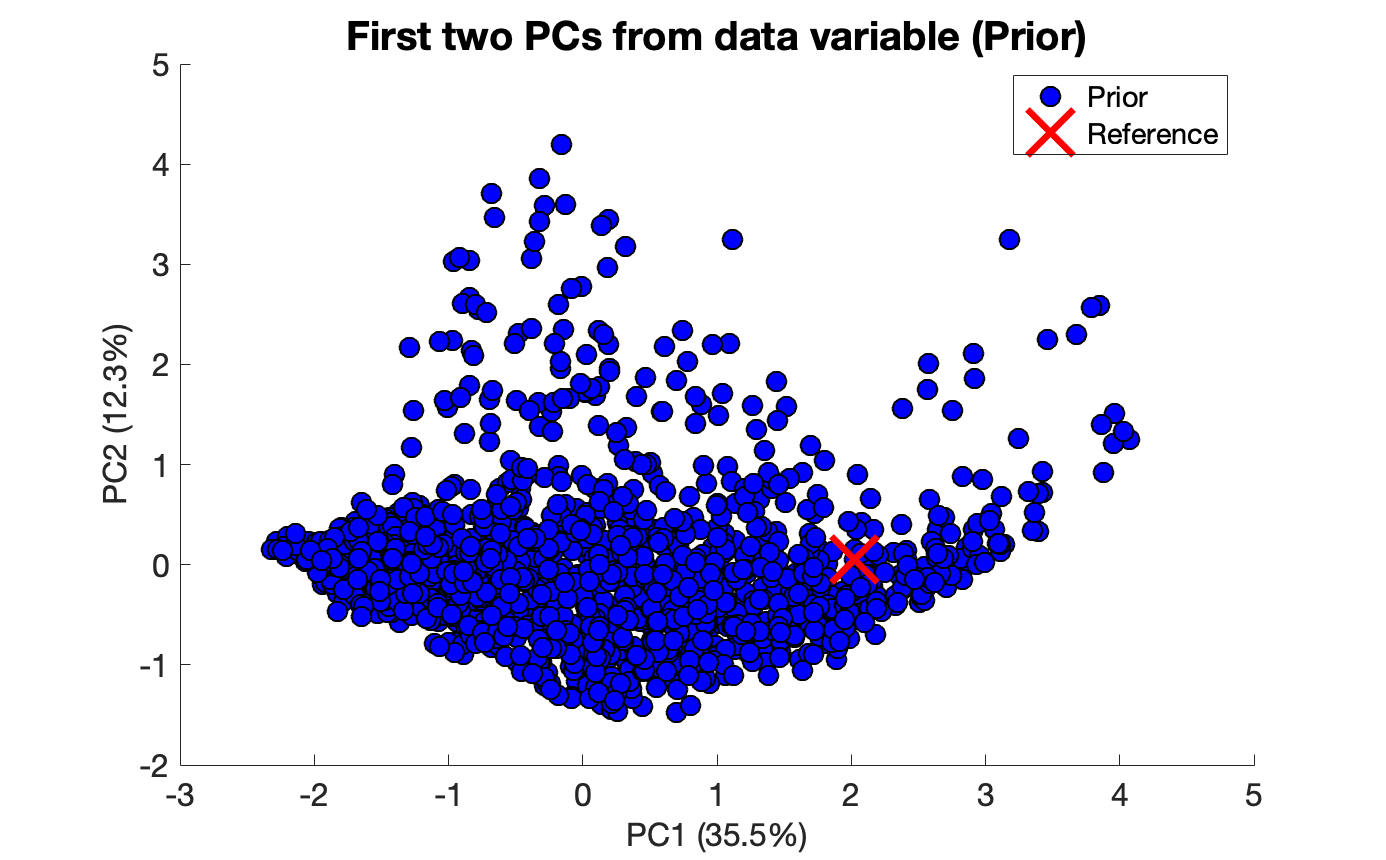

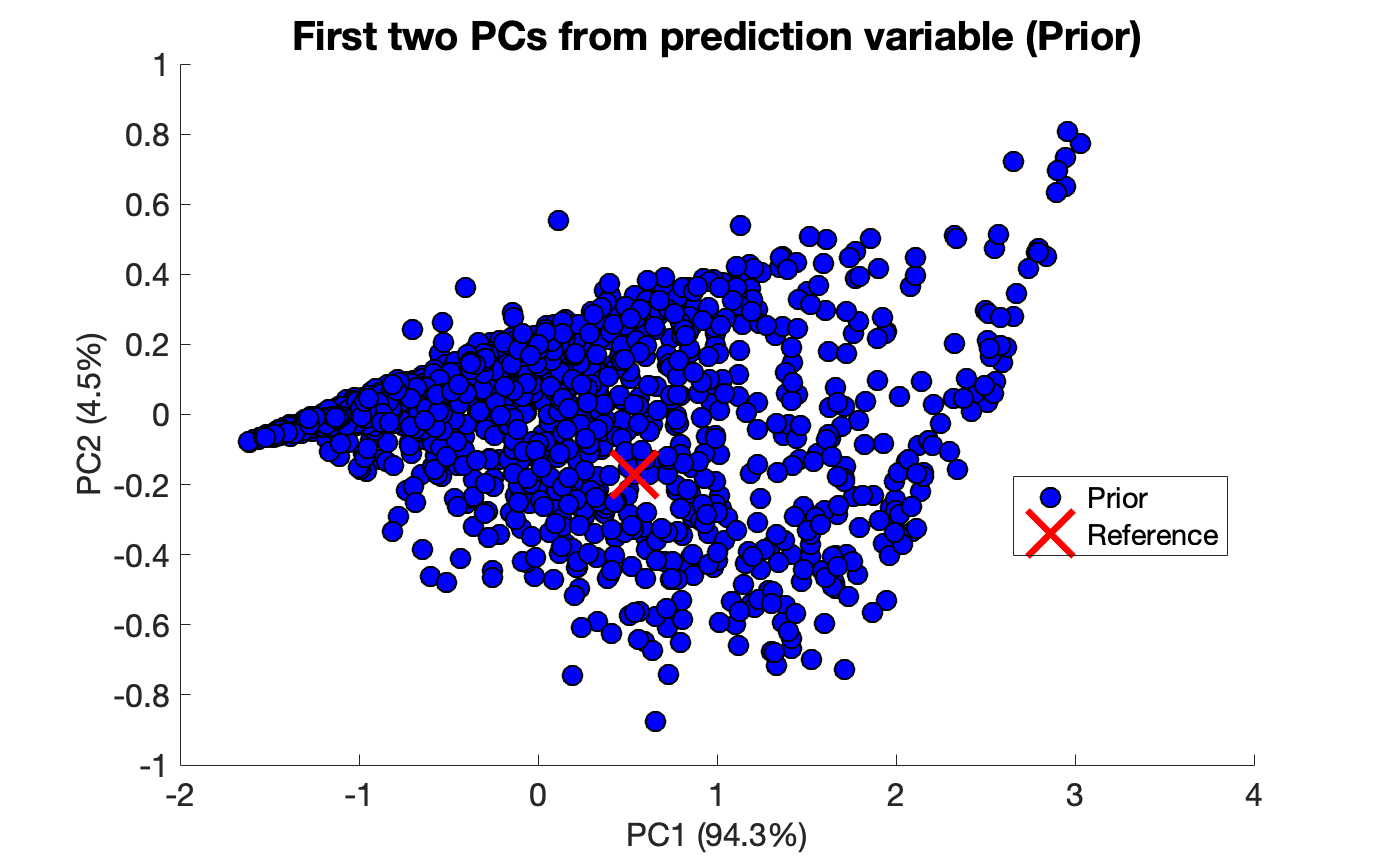

In [29]:
DisplayScores2D(Prior.Data.MixedAll.Score,[1,2],ReferenceNumber,'First two PCs from data variable (Prior)',Prior.Data.MixedAll.explained)
DisplayScores2D(Prior.Prediction.Oilrate.Mixed.Score,...
    [1,2],ReferenceNumber,'First two PCs from prediction variable (Prior)'...
    ,Prior.Prediction.Oilrate.Mixed.explained);

Corresponding scree plots can be visualized.

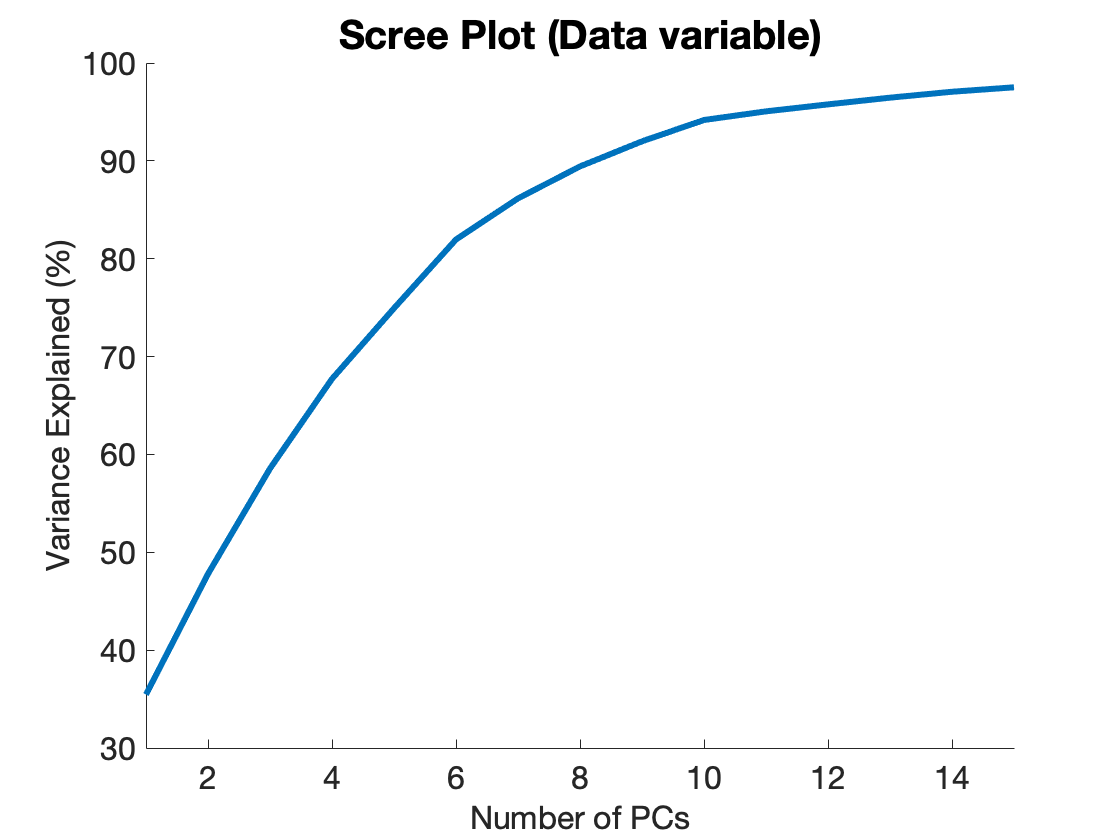

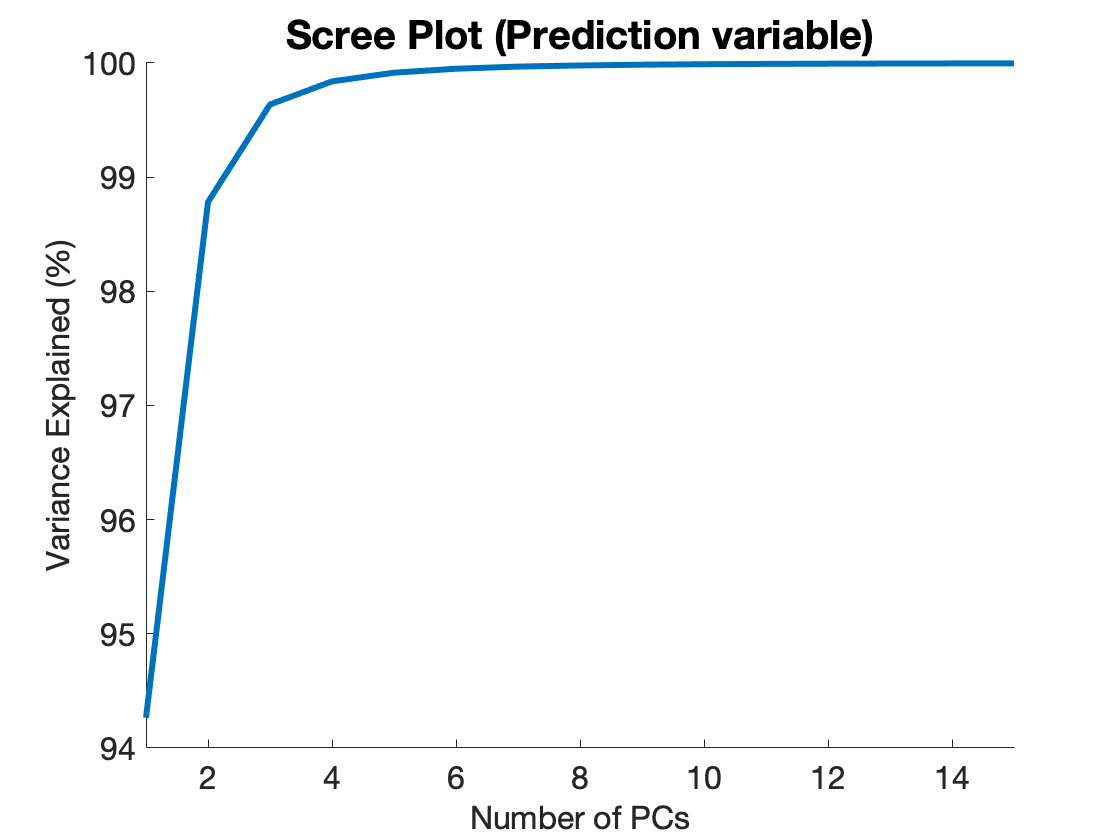

In [31]:
DisplayCumulativeVar(Prior.Data.MixedAll.cumulative,'Scree Plot (Data variable)',15);
DisplayCumulativeVar(Prior.Prediction.Oilrate.Mixed.cumulative,'Scree Plot (Prediction variable)',15);


# Sensitivity analysis

## Sensitivity analysis for data variables

In [32]:
DGSA.ParametersValues=[GlobalTotal.ParameterValues,PCAInfo_spatial.score_Selected];
DGSA.D=pdist(Prior.Data.MixedAll.Score); 
DGSA.ParametersNames=MakePCNames('PC',PCAInfo_spatial.NumPC_Selected); DGSA.ParametersNames = [GlobalTotal.Names',DGSA.ParametersNames];
DGSA.Nbcluster=3;  DGSA.MainEffects.Display.ParetoPlotbyCluster=0;DGSA.MainEffects.Display.StandardizedSensitivity=0;

DGSA.Clustering=kmedoids(DGSA.D,DGSA.Nbcluster,10);

rng(234);
DGSA = ComputeMainEffects(DGSA);

minDist  2606.75, iter 1 
minDist  2587.73, iter 3 
Bootstrapping 1 th Parameters
Bootstrapping 2 th Parameters
Bootstrapping 3 th Parameters
Bootstrapping 4 th Parameters
Bootstrapping 5 th Parameters
Bootstrapping 6 th Parameters
Bootstrapping 7 th Parameters
Bootstrapping 8 th Parameters
Bootstrapping 9 th Parameters
Bootstrapping 10 th Parameters
Bootstrapping 11 th Parameters
Bootstrapping 12 th Parameters
Bootstrapping 13 th Parameters
Bootstrapping 14 th Parameters
Bootstrapping 15 th Parameters
Bootstrapping 16 th Parameters
Bootstrapping 17 th Parameters
Bootstrapping 18 th Parameters
Bootstrapping 19 th Parameters
Bootstrapping 20 th Parameters
Bootstrapping 21 th Parameters
Bootstrapping 22 th Parameters
Bootstrapping 23 th Parameters
Bootstrapping 24 th Parameters
Bootstrapping 25 th Parameters
Bootstrapping 26 th Parameters
Bootstrapping 27 th Parameters
Bootstrapping 28 th Parameters
Bootstrapping 29 th Parameters
Bootstrapping 30 th Parameters
Bootstrapping 31 th Paramet

Bootstrapping 259 th Parameters
Bootstrapping 260 th Parameters
Bootstrapping 261 th Parameters
Bootstrapping 262 th Parameters
Bootstrapping 263 th Parameters
Bootstrapping 264 th Parameters
Bootstrapping 265 th Parameters
Bootstrapping 266 th Parameters
Bootstrapping 267 th Parameters
Bootstrapping 268 th Parameters
Bootstrapping 269 th Parameters
Bootstrapping 270 th Parameters
Bootstrapping 271 th Parameters
Bootstrapping 272 th Parameters
Bootstrapping 273 th Parameters
Bootstrapping 274 th Parameters
Bootstrapping 275 th Parameters
Bootstrapping 276 th Parameters
Bootstrapping 277 th Parameters
Bootstrapping 278 th Parameters
Bootstrapping 279 th Parameters
Bootstrapping 280 th Parameters
Bootstrapping 281 th Parameters
Bootstrapping 282 th Parameters
Bootstrapping 283 th Parameters
Bootstrapping 284 th Parameters
Bootstrapping 285 th Parameters
Bootstrapping 286 th Parameters
Bootstrapping 287 th Parameters
Bootstrapping 288 th Parameters
Bootstrapping 289 th Parameters
Bootstra

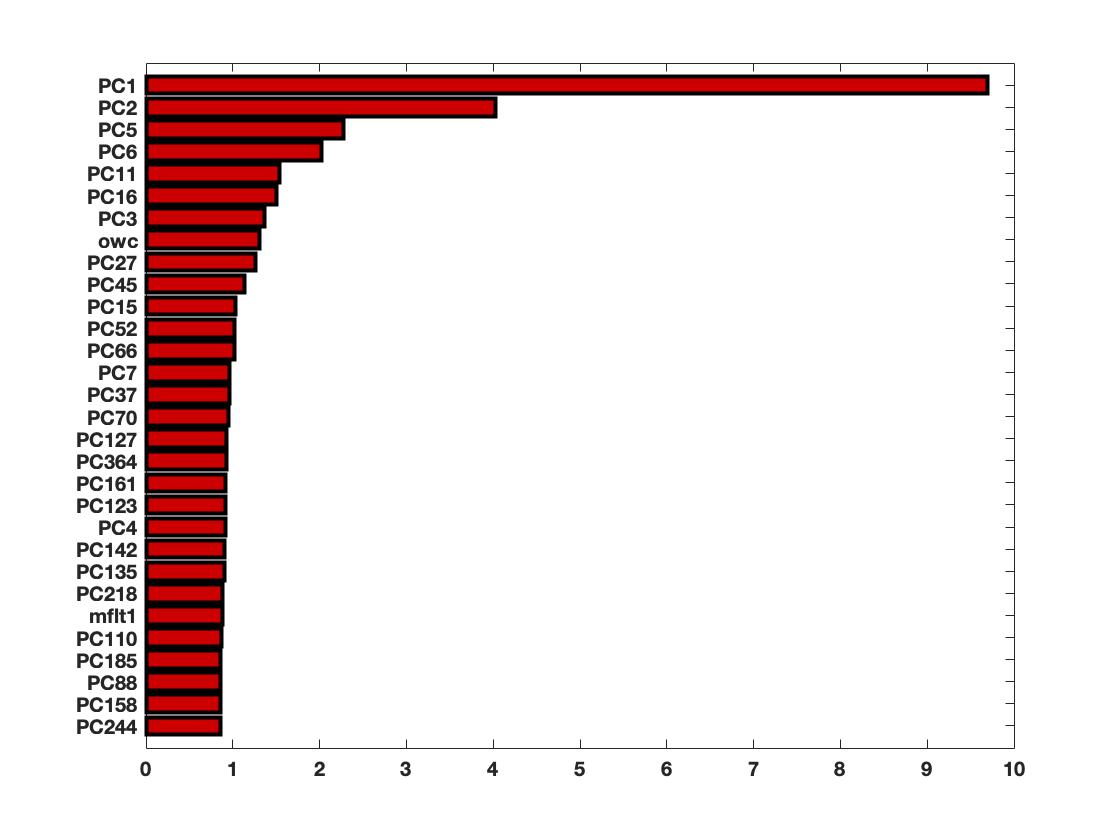

In [33]:
Pareto_GlobalSensitivity_v2(DGSA.MainEffects.SensitivityStandardized,DGSA.ParametersNames,30);

## Sensitivity analysis for prediction variables

In [34]:
DGSA_Prediction = DGSA; 
DGSA_Prediction.D = pdist(Prior.Prediction.Oilrate.Mixed.Score); 
DGSA_Prediction.Clustering = kmedoids(DGSA_Prediction.D,DGSA_Prediction.Nbcluster,10);
rng(1);
DGSA_Prediction = ComputeMainEffects(DGSA_Prediction);


minDist  588.91, iter 1 
Bootstrapping 1 th Parameters
Bootstrapping 2 th Parameters
Bootstrapping 3 th Parameters
Bootstrapping 4 th Parameters
Bootstrapping 5 th Parameters
Bootstrapping 6 th Parameters
Bootstrapping 7 th Parameters
Bootstrapping 8 th Parameters
Bootstrapping 9 th Parameters
Bootstrapping 10 th Parameters
Bootstrapping 11 th Parameters
Bootstrapping 12 th Parameters
Bootstrapping 13 th Parameters
Bootstrapping 14 th Parameters
Bootstrapping 15 th Parameters
Bootstrapping 16 th Parameters
Bootstrapping 17 th Parameters
Bootstrapping 18 th Parameters
Bootstrapping 19 th Parameters
Bootstrapping 20 th Parameters
Bootstrapping 21 th Parameters
Bootstrapping 22 th Parameters
Bootstrapping 23 th Parameters
Bootstrapping 24 th Parameters
Bootstrapping 25 th Parameters
Bootstrapping 26 th Parameters
Bootstrapping 27 th Parameters
Bootstrapping 28 th Parameters
Bootstrapping 29 th Parameters
Bootstrapping 30 th Parameters
Bootstrapping 31 th Parameters
Bootstrapping 32 th Par

Bootstrapping 260 th Parameters
Bootstrapping 261 th Parameters
Bootstrapping 262 th Parameters
Bootstrapping 263 th Parameters
Bootstrapping 264 th Parameters
Bootstrapping 265 th Parameters
Bootstrapping 266 th Parameters
Bootstrapping 267 th Parameters
Bootstrapping 268 th Parameters
Bootstrapping 269 th Parameters
Bootstrapping 270 th Parameters
Bootstrapping 271 th Parameters
Bootstrapping 272 th Parameters
Bootstrapping 273 th Parameters
Bootstrapping 274 th Parameters
Bootstrapping 275 th Parameters
Bootstrapping 276 th Parameters
Bootstrapping 277 th Parameters
Bootstrapping 278 th Parameters
Bootstrapping 279 th Parameters
Bootstrapping 280 th Parameters
Bootstrapping 281 th Parameters
Bootstrapping 282 th Parameters
Bootstrapping 283 th Parameters
Bootstrapping 284 th Parameters
Bootstrapping 285 th Parameters
Bootstrapping 286 th Parameters
Bootstrapping 287 th Parameters
Bootstrapping 288 th Parameters
Bootstrapping 289 th Parameters
Bootstrapping 290 th Parameters
Bootstra

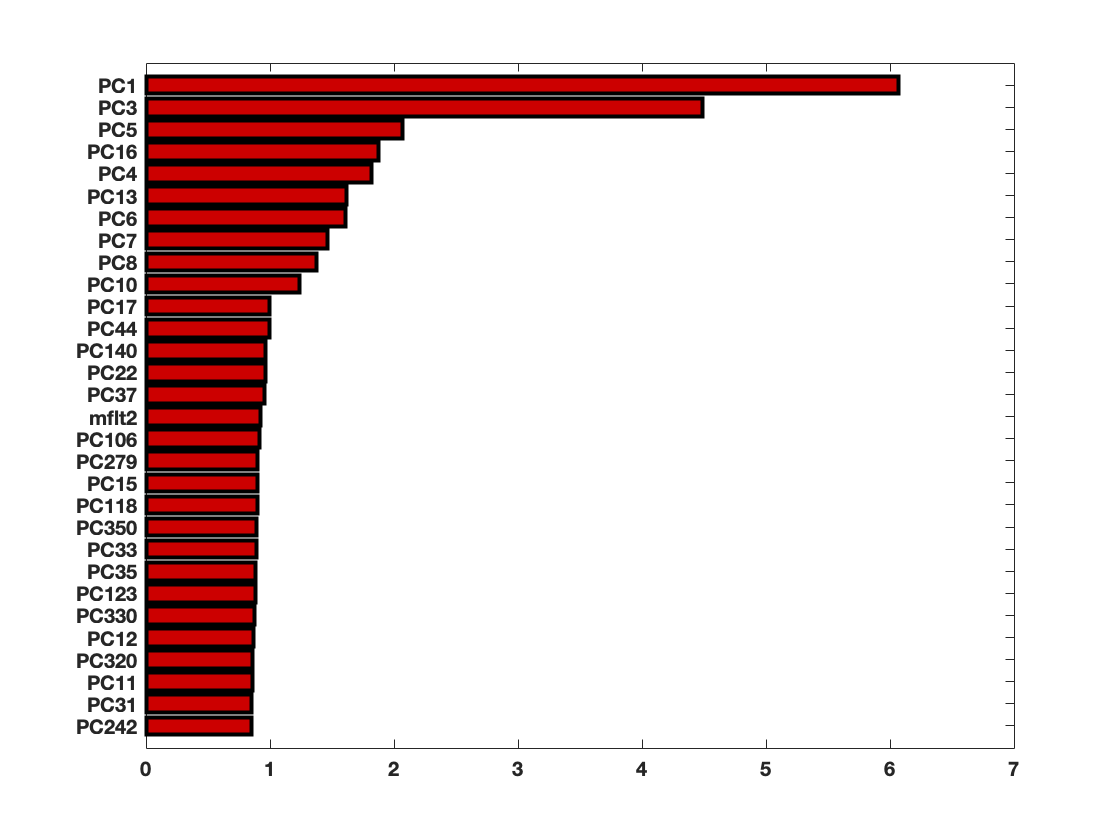

In [36]:
Pareto_GlobalSensitivity_v2(DGSA_Prediction.MainEffects.SensitivityStandardized,DGSA_Prediction.ParametersNames,30);

Split the variables (both $m_{gl}$ and $m_{sp}$) according to rank of sensitivities
* `alpha_s`: Selected variables
* `alpha_i`: Unselected variables
* `sen_index`: index of selected variables
* `insen_index`: index of insensitive variables

In [37]:
[alpha_s,alpha_i,sen_index,insen_index] = ...
    split_by_sensitivityRank(DGSA.ParametersValues,DGSA.MainEffects.SensitivityStandardized,Prior.Data.MixedAll.HowMany);

# Direct forecasting 

First check how data and prediction variables are correlated. This can be validated by applying CCA on $d^{pc}$ and $h^{pc}$.

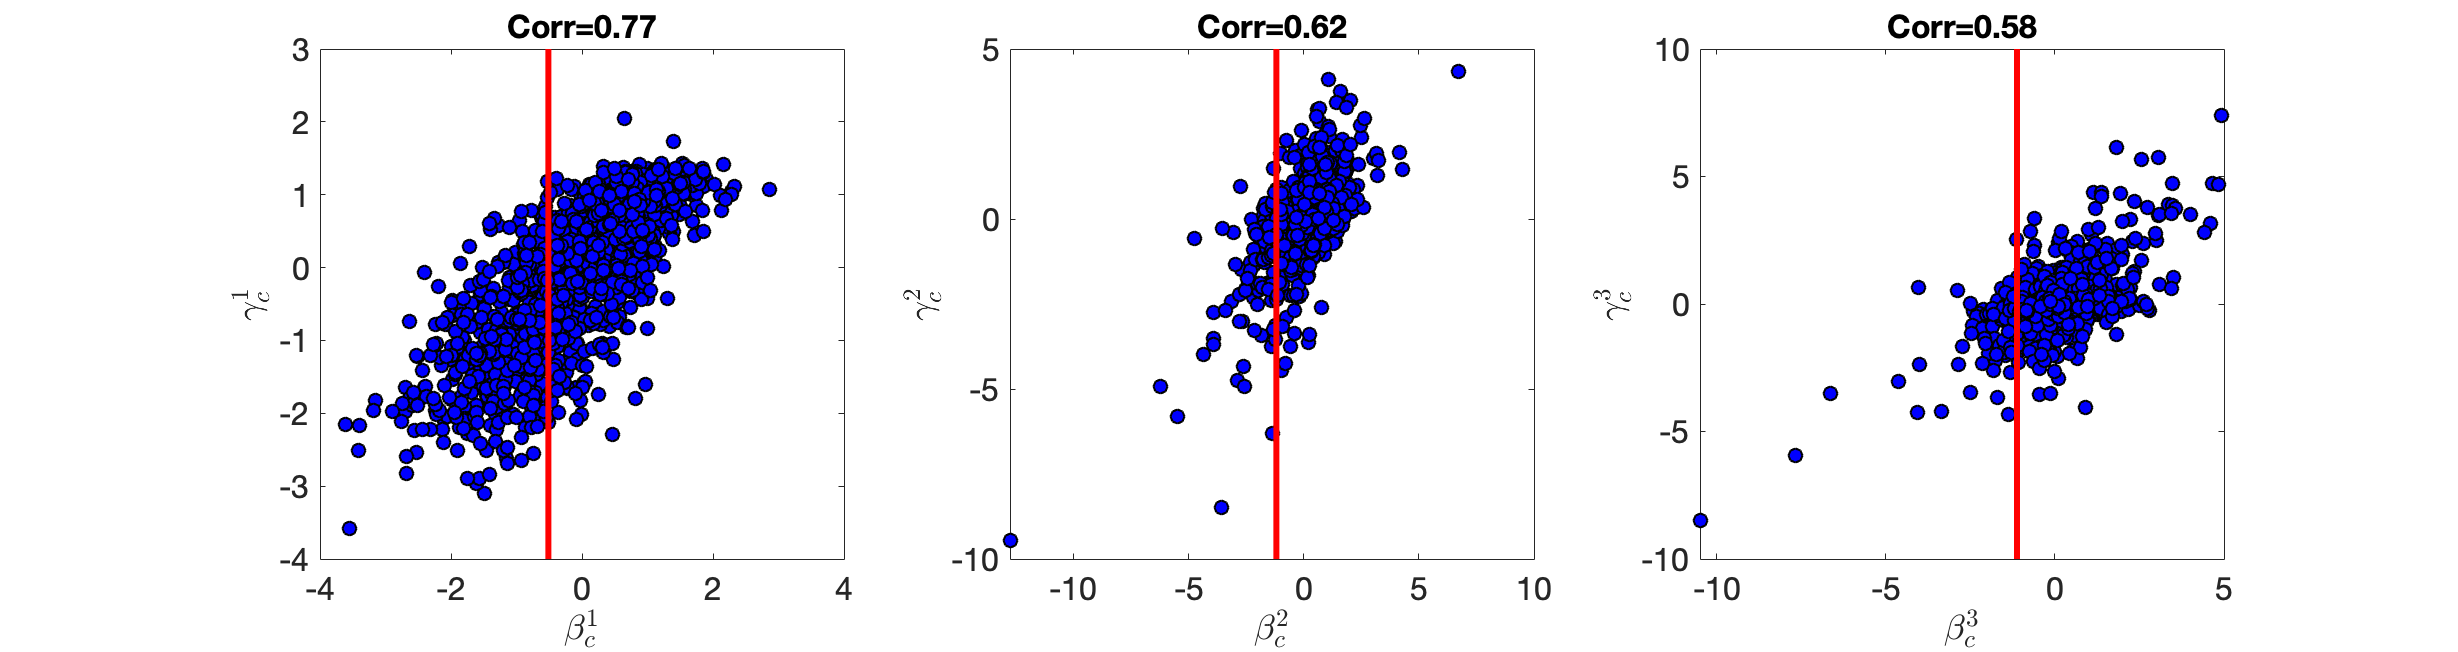

In [38]:
CCAOutputs_Data_Prediction=RunCCA...
    (Prior.Data.MixedAll.ReducedDataSet,Prior.Prediction.Oilrate.Mixed.ReducedDataSet,ReferenceNumber,6,1,'\\beta','\\gamma',3,[319 531 1229 326]);

Apply CCA to  $d^{pc}$ and $m^{pc}$.

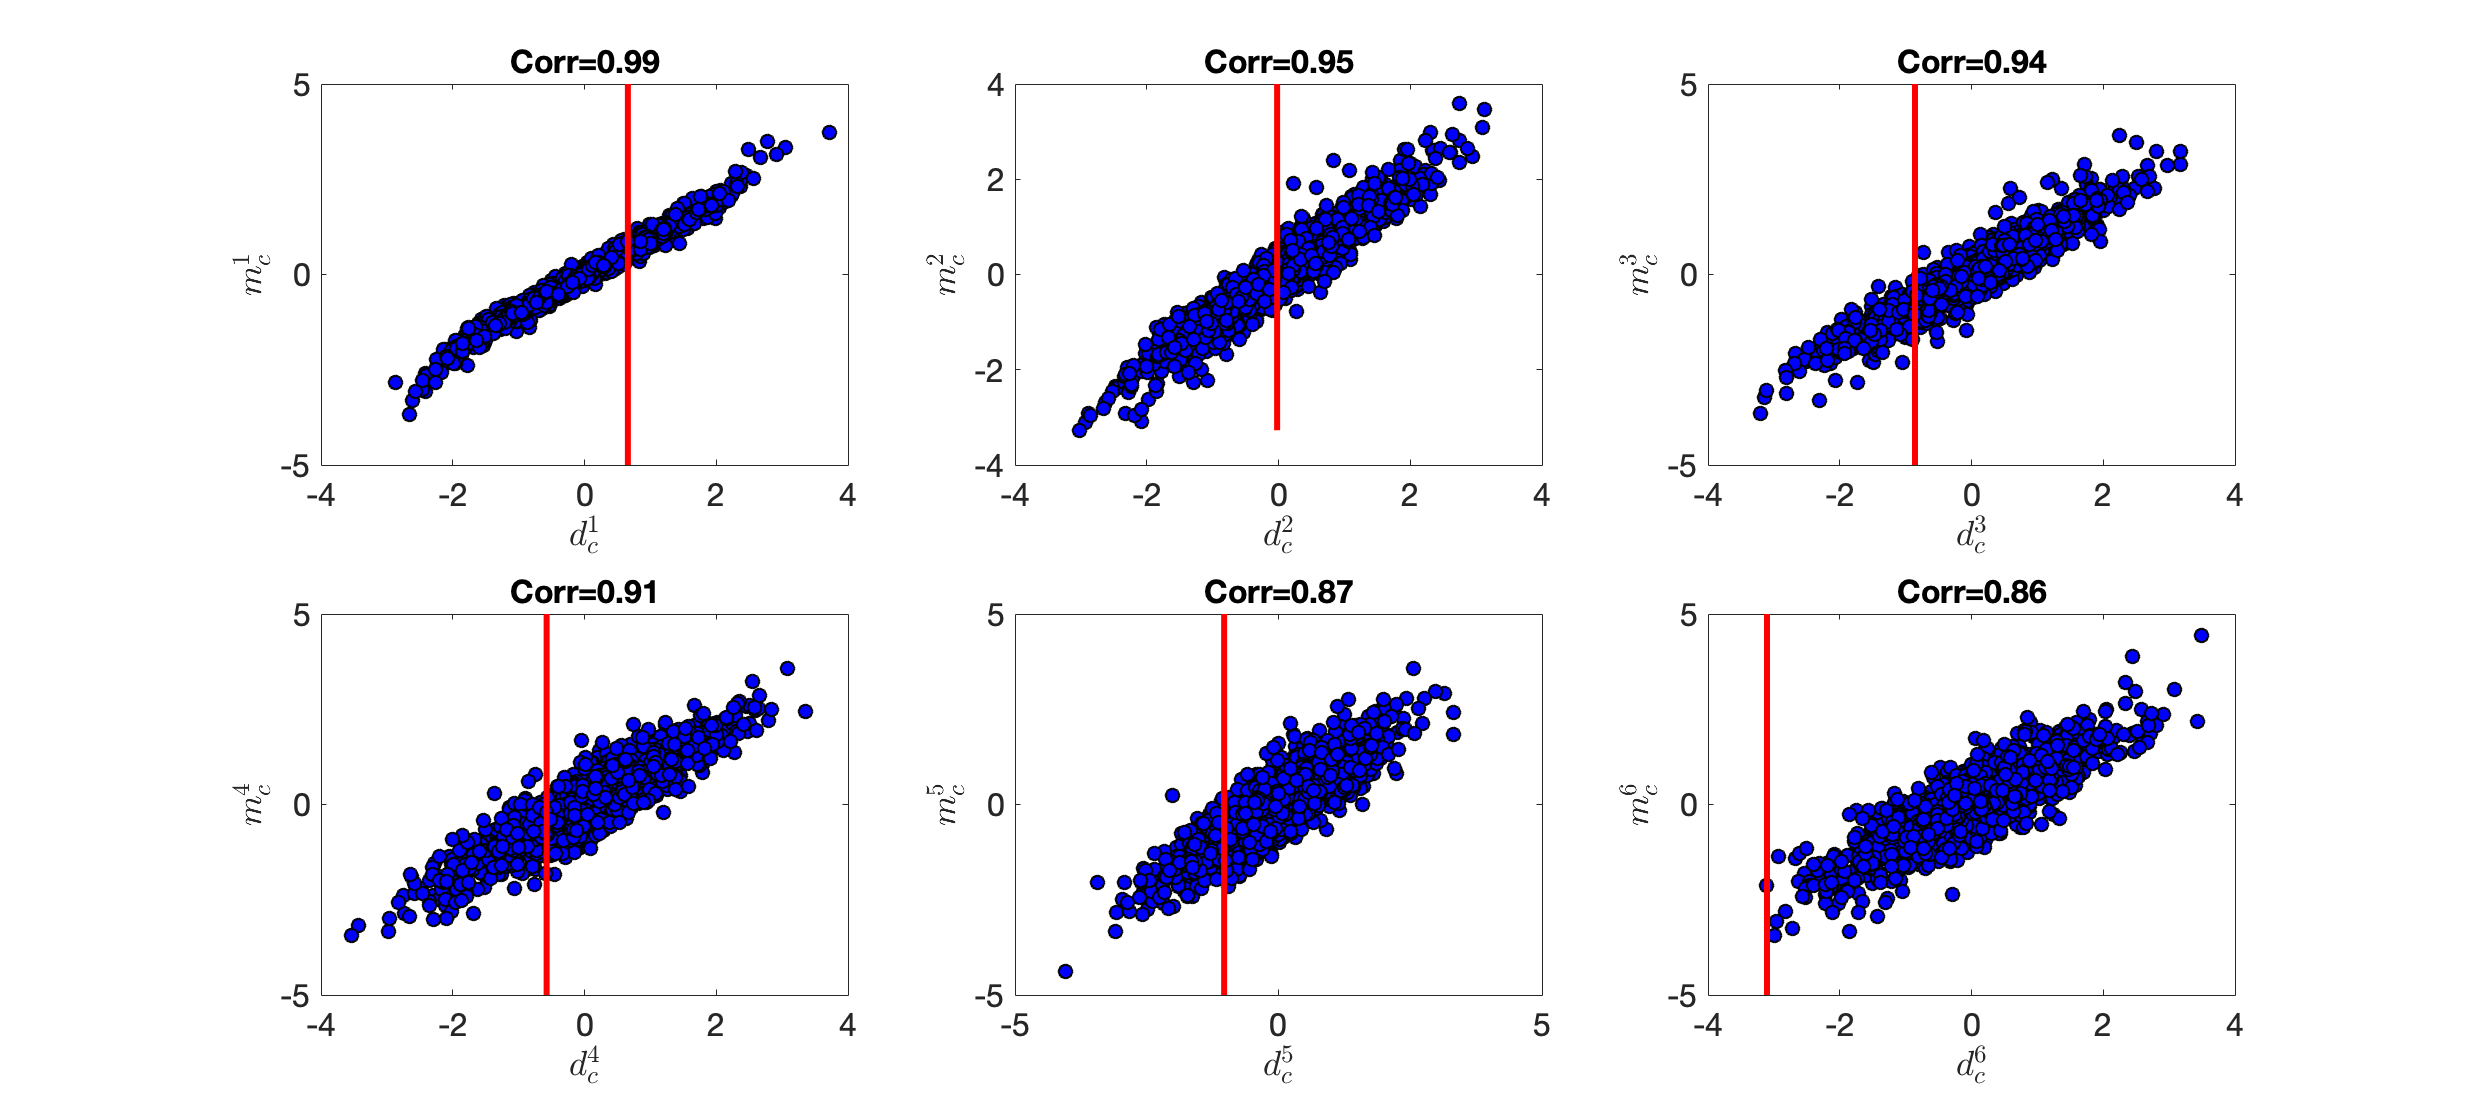

In [39]:
CCA_Result= RunCCA(Prior.Data.MixedAll.ReducedDataSet,alpha_s,ReferenceNumber,6,2,'d','m',6,[319 531 1229 326]);
set(gcf,'Position',[285 296 1235 559]);

Estimate posterior distribution at canonical covariate space

In [40]:
[CCA_Result.mu_posterior, CCA_Result.C_posterior,CCA_Result.G,CCA_Result.Dc,CCA_Result.Hc,CCA_Result.DcPredicted]=...
    ComputePosterior(Prior.Data.MixedAll.ReducedDataSet,CCA_Result,Prior.Data.MixedAll.ReducedDataSet(ReferenceNumber,:));

Sample from the posterior distibution. Recall that we are only using $alpha_s$, $alpha_i$ will be randomized.

In [41]:
rng(3233455); 
alpha_posterior = SampleFromCCAPosterior_with_prediction(CCA_Result,alpha_s,Prior.Data.MixedAll.ReducedDataSet,4000);

Remove samples that lie oustide priors

In [42]:
[alpha_posterior,IndiciesToRemove]=RemoveSamplesViolatingPriors(alpha_s,alpha_posterior);

Unselected parameters are randomized according to their prior distributions.

In [43]:
Insensitive_alpha_sampled = SampleFromEmpiricalDistribution(alpha_i,size(alpha_posterior,1),3235234);

100 dim. sampling is completed


Combine samples of selected and unselected parameters

In [44]:
[m_global_posterior,m_local_posterior] = ...
    CombineSamples(alpha_posterior,Insensitive_alpha_sampled,sen_index,insen_index,size(GlobalTotal.ParameterValues,2));

Higher order PC components also need to be randomized. 

In [45]:
spatial_vars_high_order =...
    SampleFromEmpiricalDistribution(PCAInfo_spatial.score_All(:,PCAInfo_spatial.NumPC_Selected+1:end)...
    ,size(m_local_posterior,1),23143);

100 dim. sampling is completed
200 dim. sampling is completed
300 dim. sampling is completed
400 dim. sampling is completed
500 dim. sampling is completed
600 dim. sampling is completed
700 dim. sampling is completed
800 dim. sampling is completed
900 dim. sampling is completed
1000 dim. sampling is completed
1100 dim. sampling is completed


Restore $m_{sp}$ from $\alpha$.

In [46]:
spatial_vars_noise_added = [m_local_posterior,spatial_vars_high_order];
m_posteriors  = BackTransform_alpha(spatial_vars_noise_added,PCAInfo_spatial);

Investigate the distributions by histogram.

For global parameters:

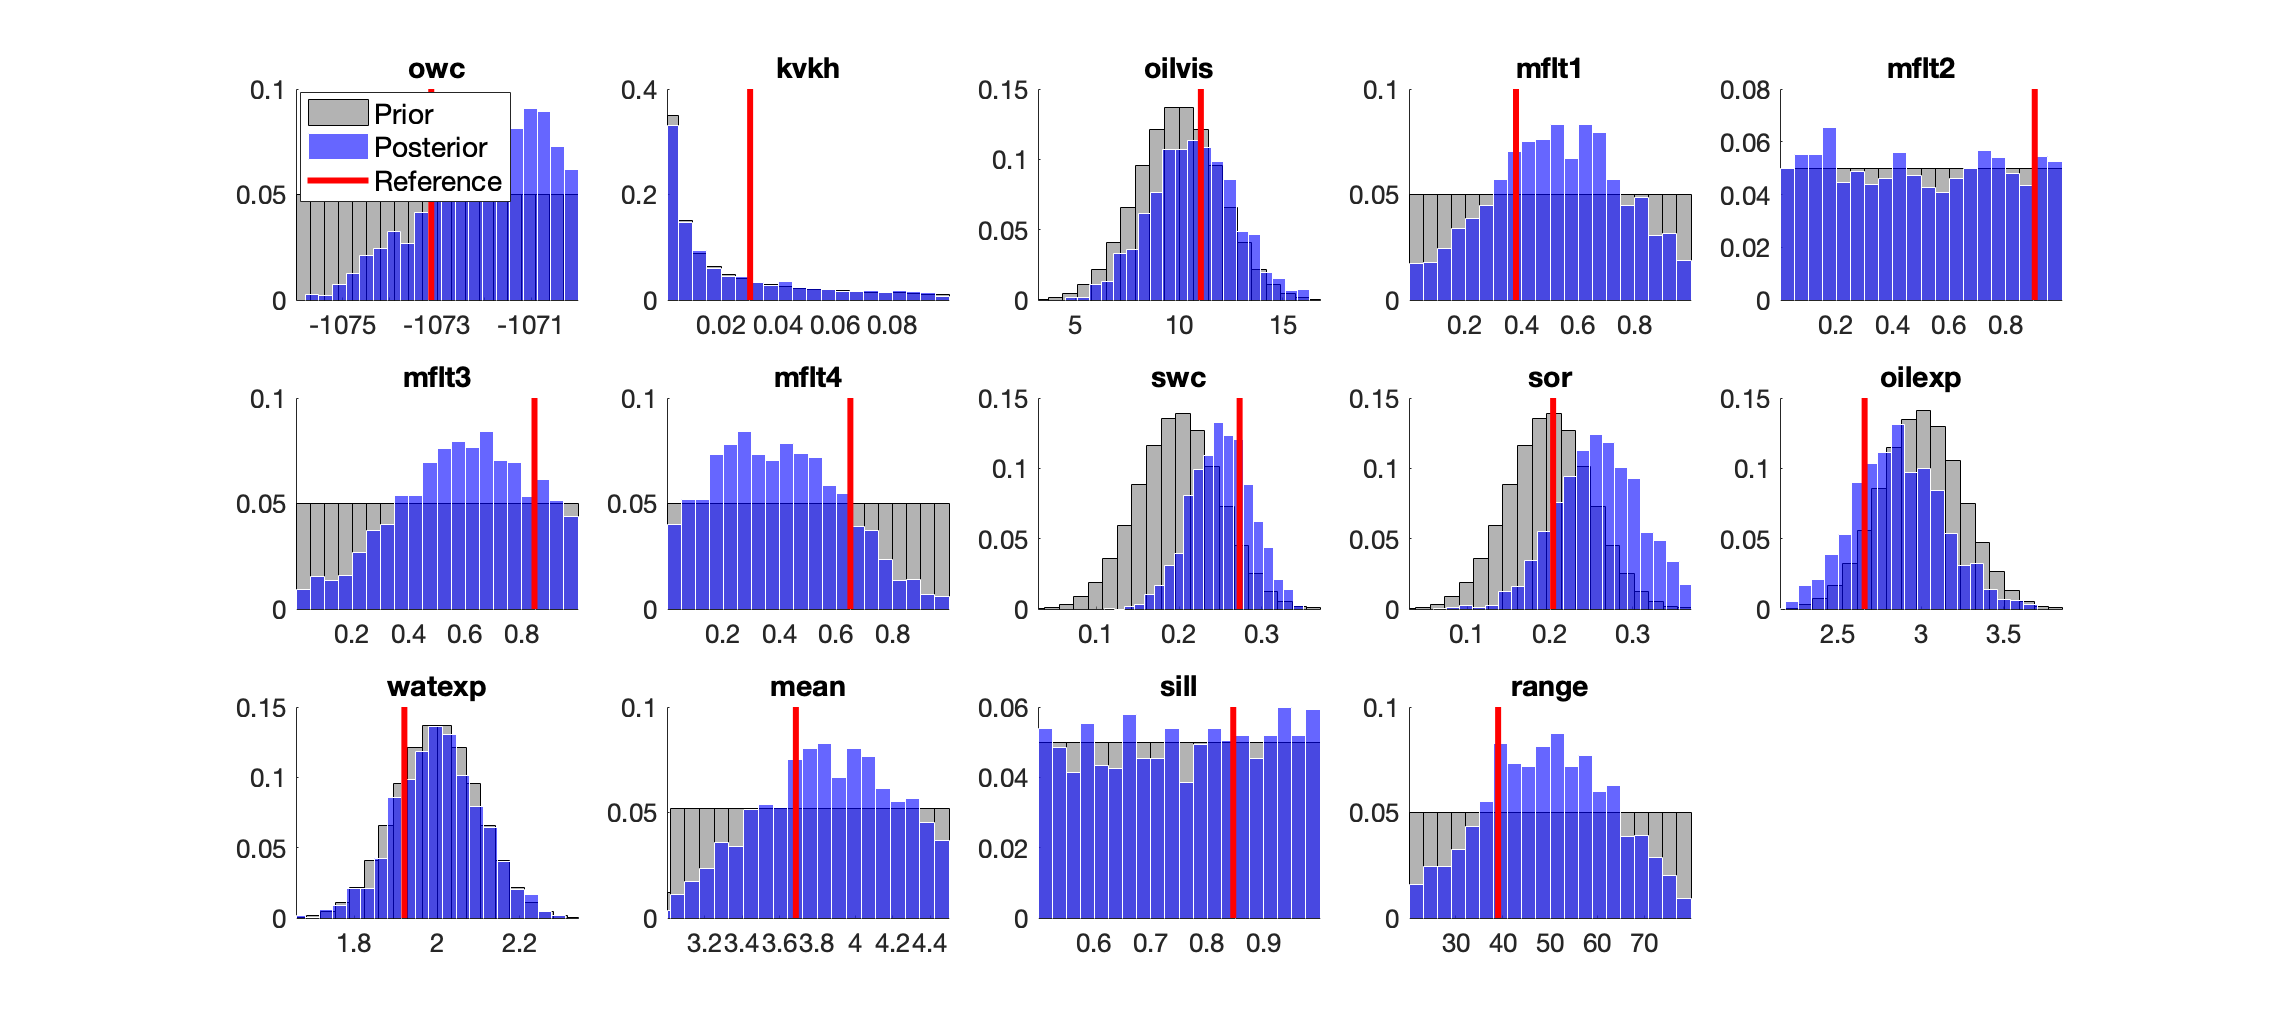

In [47]:
CompareDistributionHistograms_Two(GlobalTotal.ParameterValues,m_global_posterior,14,3,GlobalTotal.ParameterValues(ReferenceNumber,:),{'Prior','Posterior','Reference'},GlobalTotal.Names);
set(gcf,'Position',[397 462 1139 516]);

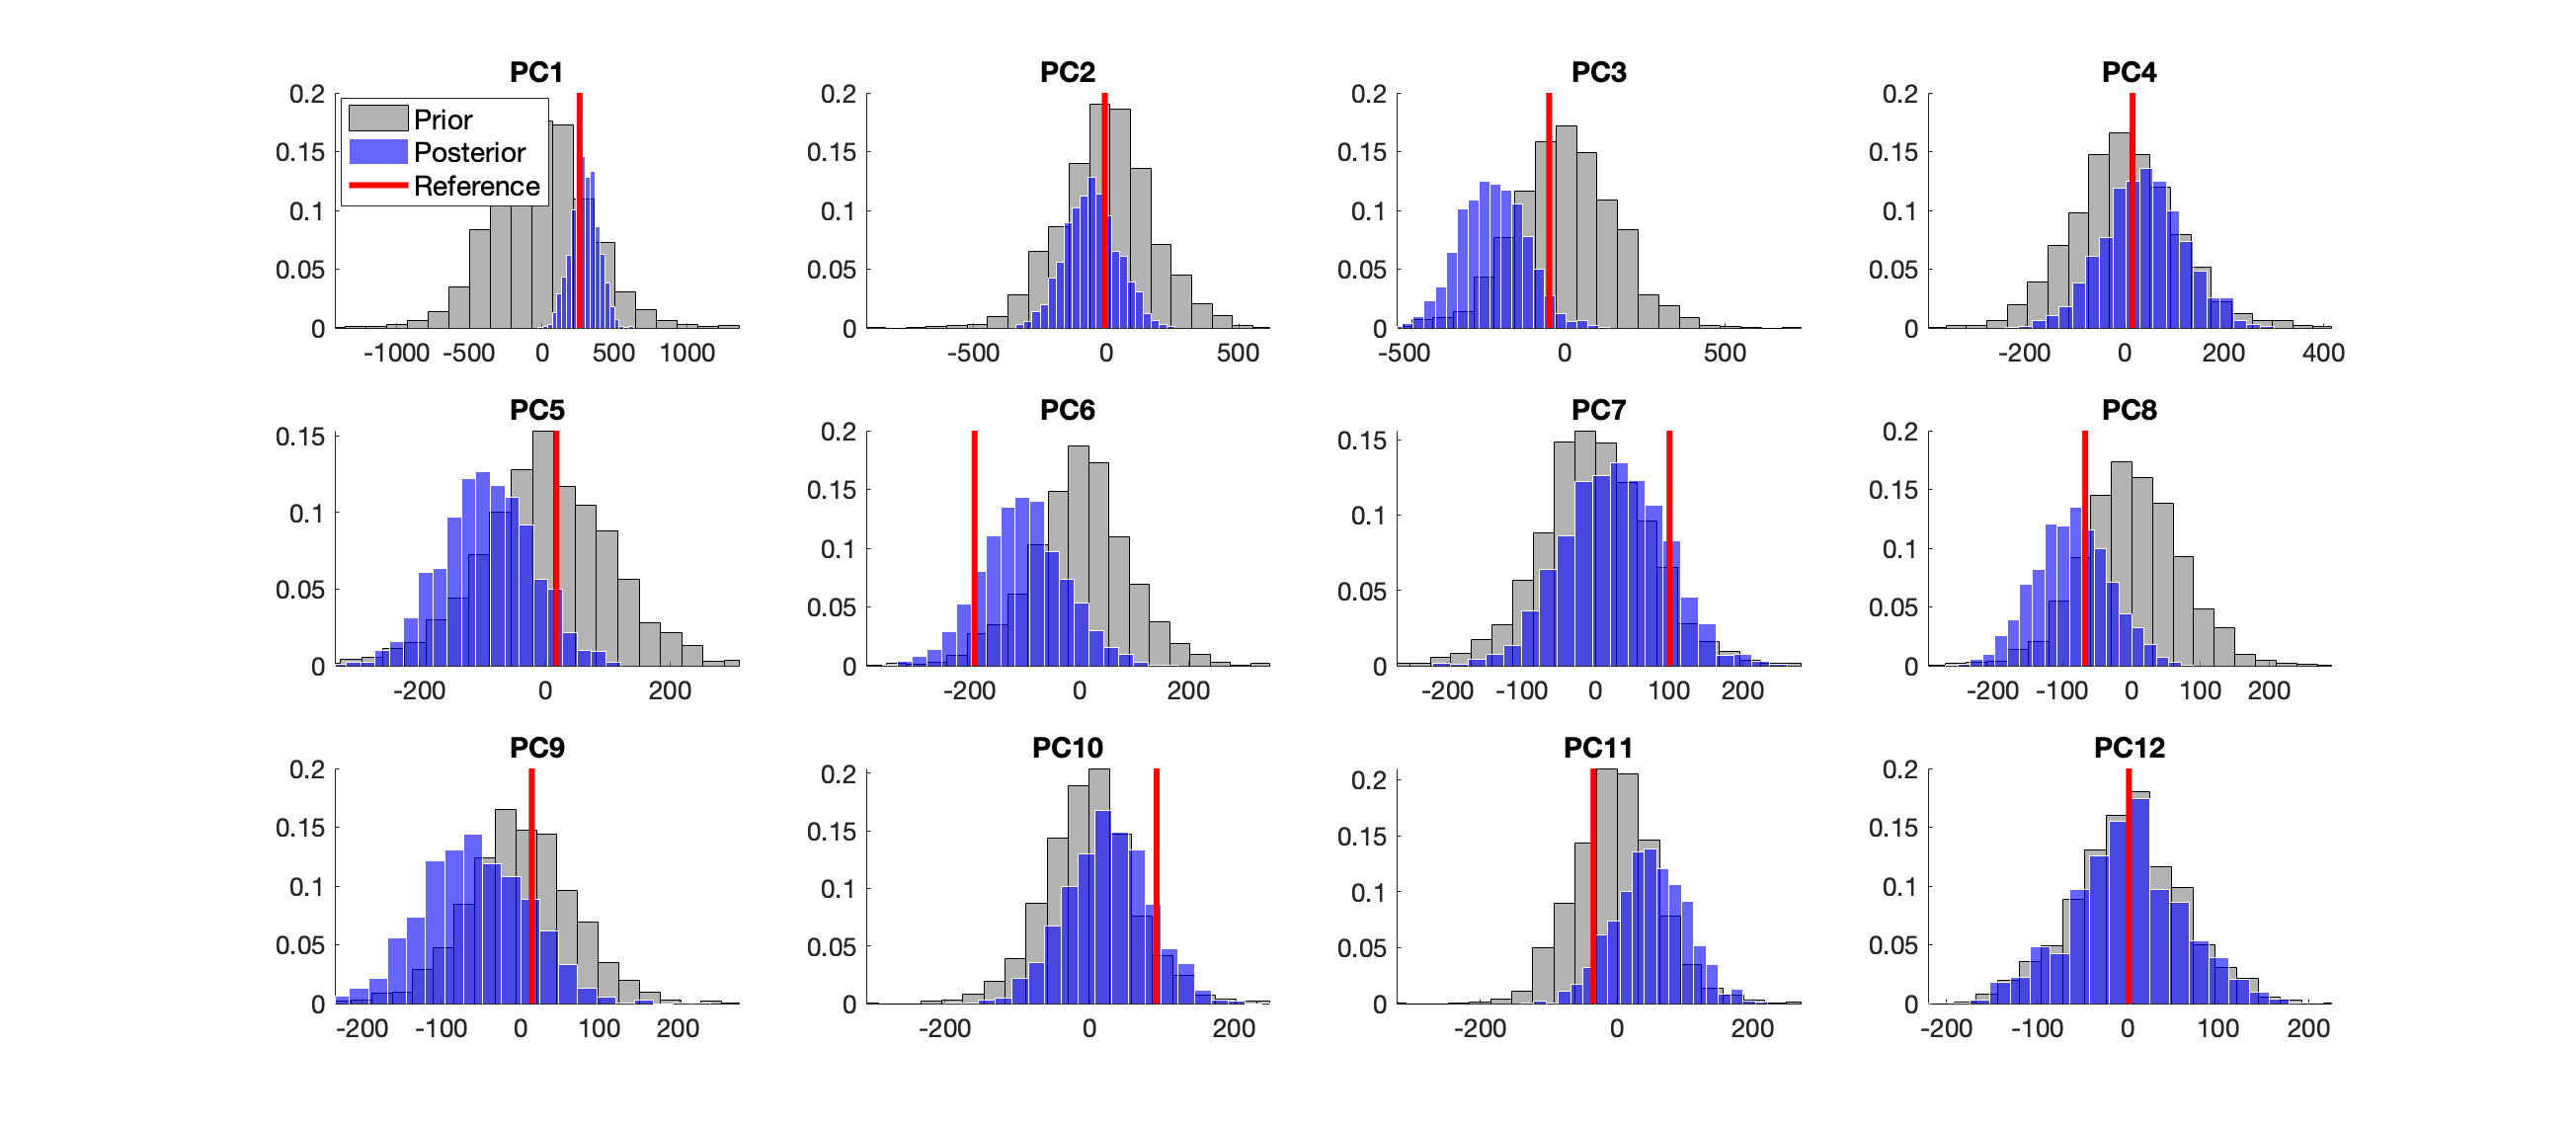

In [48]:
CompareDistributionHistograms_Two(PCAInfo_spatial.score_Selected,m_local_posterior,12,3,PCAInfo_spatial.score_Selected(ReferenceNumber,:),{'Prior','Posterior','Reference'});
set(gcf,'Position',[291 407 1304 571]);

Now, we need to run forward model evaluations with `m_global_posterior`, `m_local_posterior`. The results are presented at the [notebook2](Notebook2_Post-processing).